*Antonio Coín Castro*     


# Bayesian Functional Logistic Regression

In [1]:
# -- Libraries

import os
import pickle
import sys

import arviz as az
import numpy as np
import pandas as pd
import skfda

from IPython.display import display
from matplotlib import pyplot as plt
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.kernel_smoothers import \
    NadarayaWatsonSmoother as NW
from skfda.representation.basis import BSpline, Fourier
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import StratifiedKFold, train_test_split

import bfr.bayesian_model as bayesian_model
import bfr.plot_utils as plot_utils
import bfr.preprocessing as preprocessing
import bfr.simulation as simulation
import bfr.utils as utils

from bfr._fpls import APLS, FPLS, FPLSBasis
from bfr.mle import compute_mle
from bfr.sklearn_utils import PLSRegressionWrapper

In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)
pd.set_option("styler.format.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the binary $\{0,1\}$-model

$$
\mathbb P(Y=1\mid X=x) = \frac{1}{1 + \exp\{-\alpha_0-\Psi^{-1}_{x}(\alpha)\}},
$$

i.e., each $Y_i$ can be seen as a Bernoulli random variable $\mathcal B(p(x_i))$ with

$$
p(x_i)\equiv p_i=\mathbb P(Y_i=1\mid X_i=x_i) = \frac{1}{1 + \exp\left\{-\alpha_0-\displaystyle\sum_{j=1}^p \beta_jx_i(\tau_j)\right\}}.
$$

Note that $\mathbb E[Y_i]=p_i$ and $\operatorname{Var}(Y_i)=p_i(1-p_i)$.

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)\right]^{-1}\right).
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log \sigma)$, the joint log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \sum_{i=1}^n \left[ \left(\alpha_0 + \Psi^{-1}_{x_i}(\alpha)\right)y_i - \log\left(1 + \exp\left\{\alpha_0 + \Psi_{x_i}^{-1}(\alpha)\right\}\right)\right] +
\frac{1}{2}\log |G_\tau| - p\log \sigma -\frac{1}{2g\sigma^2} (\beta - b_0)'G_\tau(\beta - b_0).  
$$

The metrics considered for model evaluation will be:

- Accuracy.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, and a value of $\alpha_0=-0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{0.5 + 5X_i(0.1) - 10X_i(0.8)\right\}}\right)
$$

or

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{0.5 -\int_0^1 \beta(t)X_i(t)\, dt\right\}}\right),
$$

where $\beta(t) \in L^2[0, 1]$.

Another possibility is to generate a dataset from two different Gaussian processes, and label them according to the (known) distribution of $X^{(j)}$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [3]:
# -- Data generation parameters

SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"  # 'L2', 'RKHS' or 'MIXTURE'
REAL_DATA = "Growth"
NOISE = 0.1

INITIAL_SMOOTHING = None  # None, NW' or 'Basis'
N_BASIS = 16
SCALE_PREDICTORS = False

kernel_fn = simulation.fractional_brownian_kernel
kernel_fn2 = simulation.squared_exponential_kernel
basis = BSpline(n_basis=N_BASIS)
smoothing_params = np.logspace(-4, 4, 50)

n_train, n_test = 100, 50
N = 100
tau_range = (0, 1)

In [4]:
# -- Dataset generation

if SYNTHETIC_DATA:
    grid = np.linspace(tau_range[0] + 1./N, tau_range[1], N)
    mean_vector = None
    mean_vector2 = np.ones(N)
    alpha0_true = -0.5

    if MODEL_GEN == "MIXTURE":
        x, y = utils.generate_classification_dataset(
            grid, kernel_fn, kernel_fn2,
            n_train + n_test, rng,
            mean_vector, mean_vector2)
    else:
        if MODEL_GEN == "L2":
            beta_coef = simulation.cholaquidis_scenario3
            x, y_lin = simulation.generate_gp_l2_dataset(
                grid, kernel_fn,
                n_train + n_test, beta_coef,
                alpha0_true, 0.0, rng=rng
            )
        elif MODEL_GEN == "RKHS":
            beta_true = np.array([-5., 10.])
            tau_true = np.array([0.1, 0.8])
            x, y_lin = simulation.generate_gp_rkhs_dataset(
                grid, kernel_fn,
                n_train + n_test, beta_true, tau_true,
                alpha0_true, 0.0, rng=rng
            )
        else:
            raise ValueError("Invalid model generation strategy.")

        # Transform linear response for logistic model
        y = bayesian_model.probability_to_label(
            y_lin, random_noise=NOISE, rng=rng)

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x,
        y,
        train_size=n_train,
        stratify=y,
        random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:  # Real data
    if REAL_DATA == "Medflies":
        x, y = skfda.datasets.fetch_medflies(return_X_y=True)
    elif REAL_DATA == "Growth":
        x, y = skfda.datasets.fetch_growth(return_X_y=True)
    else:
        raise ValueError("REAL_DATA must be 'Medflies' or 'Growth'.")

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.7, stratify=y, random_state=SEED)

    N = len(X_fd.grid_points[0])
    grid = grid = preprocessing.normalize_grid(
        x.grid_points[0], tau_range[0], tau_range[1])
    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Smooth data

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    X_fd, best_smoother, X_test_fd = preprocessing.smooth_data(
        X_fd,
        smoother,
        smoothing_params,
        X_test_fd
    )

    print(
        "Smoother: {}".format(
            best_smoother.best_estimator_.__class__.__name__))
    print(
        "Smoothing parameter: {:.3f}".format(
            best_smoother.best_params_['smoothing_parameter']))

# Standardize data
X_fd, X_test_fd = preprocessing.standardize_predictors(
    X_fd, X_test_fd, SCALE_PREDICTORS)


# Get data matrices

X = X_fd.data_matrix.reshape(-1, N)
X_test = X_test_fd.data_matrix.reshape(-1, N)

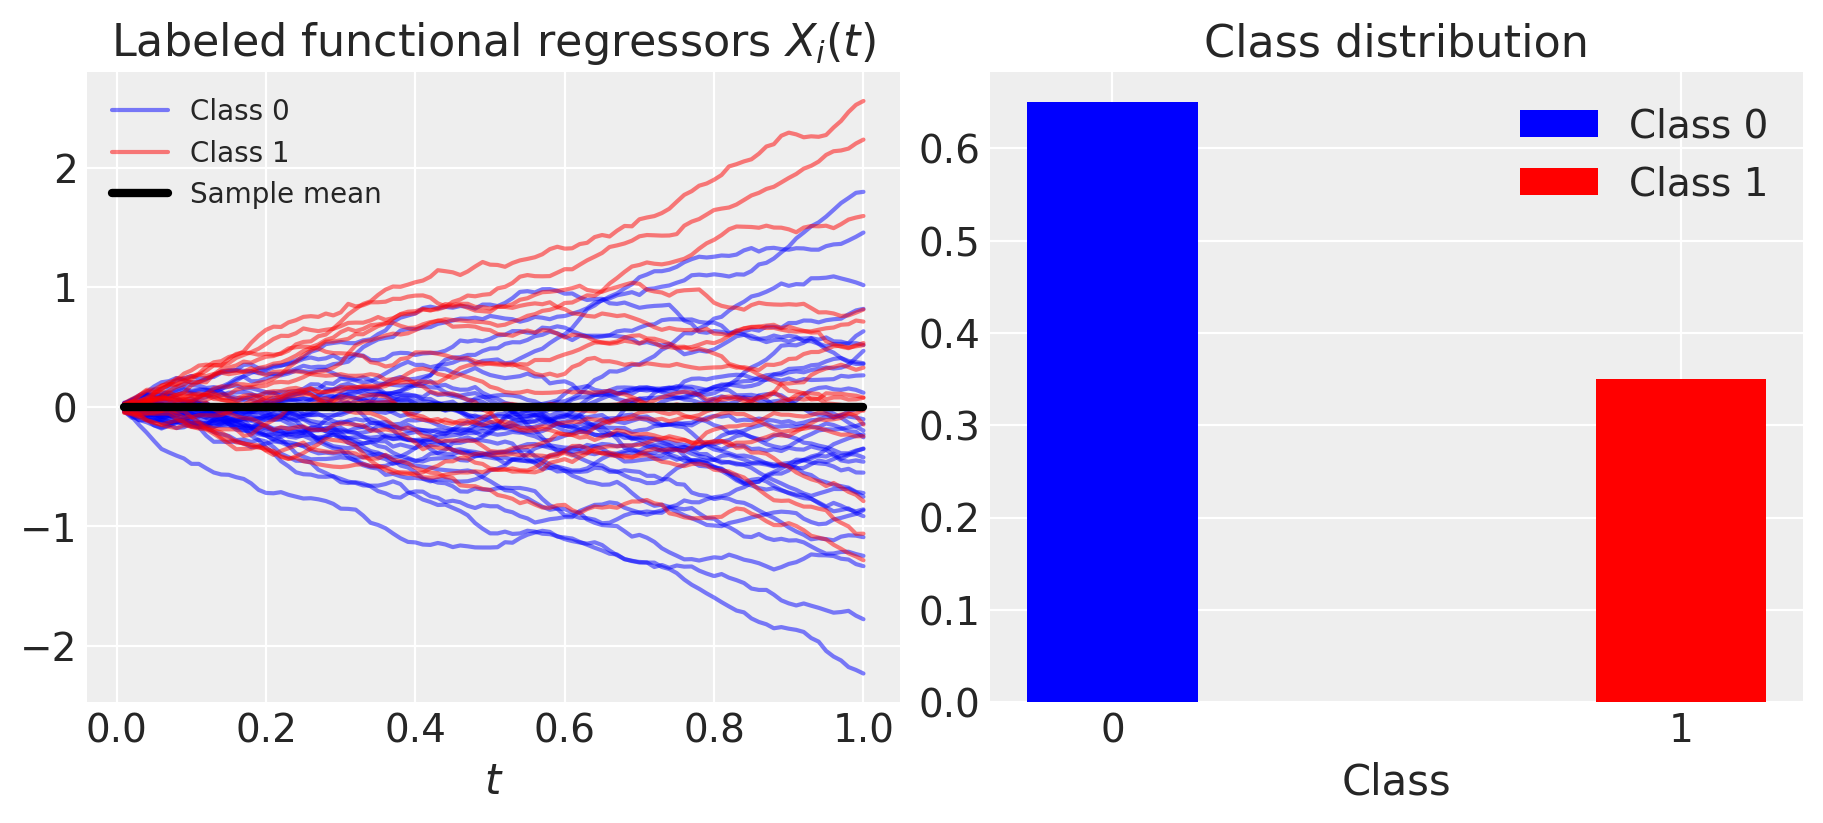

In [26]:
# -- Dataset visualization

if SYNTHETIC_DATA:
    n_samples = n_train//2
elif REAL_DATA == "Medflies":
    n_samples = n_train//5
else:
    n_samples = n_train

plot_utils.plot_dataset_classification(
    X,
    Y,
    n_samples=n_samples
)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [5]:
# -- Model hyperparameters

p_max = 3
g = 5
eta = 0.01

mle_method = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
mle_strategy = 'global'

prior_p = {
    1: 0.10,
    2: 0.60,
    3: 0.30,
}

beta_range = (-500, 500)

INCLUDE_P = False
TRANSFORM_TAU = False
TRANSFORM_SIGMA = True
FIT_SK = False
COMPUTE_MLE = False

In [6]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if INCLUDE_P:
    theta_names = ["p"] + theta_names

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]
if INCLUDE_P:
    theta_labels_grouped = [r"$p$"] + theta_labels_grouped

# Individual labels
theta_labels = [] if not INCLUDE_P else [theta_labels_grouped[0]]
for i in range(p_max):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_max):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
dim_name = "theta"
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={dim_name: dict(
        zip(np.arange(p_max), np.arange(1, p_max + 1)))}
)

In [7]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

if TRANSFORM_SIGMA:
    sigma2_ttr = bayesian_model.LogSq()
else:
    sigma2_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_max,
    grid,
    include_p=INCLUDE_P,
    names=theta_names,
    labels=theta_labels,
    labeller=theta_labeller,
    tau_range=tau_range,
    beta_range=beta_range,
    tau_ttr=tau_ttr,
    sigma2_ttr=sigma2_ttr
)

# Statistics for posterior predictive checks
point_estimators_bpv = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)
]

# Folds for CV
folds = StratifiedKFold(shuffle=True, random_state=SEED)

# Column to order results
sort_by = -1

## Sklearn model comparison

In [8]:
# -- Select family of classifiers

Cs = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, X.shape[1]]
n_components = [2, 3, 4, 5, 10]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]
n_neighbors = [3, 5, 7]

basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]

basis_fpls = []
for p in n_components:
    try:
        basis_fpls.append(FPLSBasis(X_fd, Y, n_basis=p))
    except ValueError:
        print(f"Can't create FPLSBasis with n_basis={p}")
        continue

ridge_regressors = [Ridge(alpha=C) for C in Cs]
lasso_regressors = [Lasso(alpha=C) for C in Cs]
pls_regressors = [PLSRegressionWrapper(n_components=p) for p in n_components]
fpls_regressors = [FPLS(n_components=p) for p in n_components]
apls_regressors = [APLS(n_components=p) for p in n_components]


params_clf = {"clf__C": Cs}
params_svm = {"clf__gamma": ['auto', 'scale']}
params_select = {"selector__p": n_selected}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}
params_basis_fpca = {"basis__n_basis": n_components}
params_basis_fpls = {"basis__basis": basis_fpls}
params_var_sel = {"var_sel__n_features_to_select": n_components}
params_knn = {"clf__n_neighbors": n_neighbors,
              "clf__weights": ['uniform', 'distance']}
params_depth = {"clf__depth_method": [ModifiedBandDepth(), IntegratedDepth()]}
params_mrmr = {"var_sel__method": ["MID", "MIQ"]}
params_base_regressors_ridge = {"clf__base_regressor": ridge_regressors}
params_base_regressors_lasso = {"clf__base_regressor": lasso_regressors}
params_base_regressors_pls = {"clf__base_regressor": pls_regressors}
params_base_regressors_fpls = {"clf__base_regressor": fpls_regressors}
params_base_regressors_apls = {"clf__base_regressor": apls_regressors}

classifiers = utils.logistic_regression_comparison_suite(
    params_clf,
    params_base_regressors_ridge,
    params_base_regressors_lasso,
    params_base_regressors_pls,
    params_base_regressors_fpls,
    params_base_regressors_apls,
    params_select,
    params_dim_red,
    params_var_sel,
    params_svm,
    params_depth,
    params_knn,
    params_basis,
    random_state=SEED,
)

In [9]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, clf_cv = utils.cv_sk(
        classifiers,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        folds,
        kind='logistic',
        n_jobs=N_CORES,
        sort_by=sort_by,
        verbose=True,
    )
    display(df_metrics_sk.style.hide(axis="index"))

## Maximum Likelihood Estimator

In [10]:
# -- MLE computation

if True:
    print(f"-- Computing MLE with {N_CORES} independent runs --")

    theta_space_fixed = theta_space.copy_p_fixed()

    mle_theta, bic = compute_mle(
        X,
        Y,
        theta_space_fixed,
        kind='logistic',
        method=mle_method,
        strategy=mle_strategy,
        n_jobs=N_CORES,
        rng=rng
    )

    Y_pred_mle = bayesian_model.generate_response_logistic(
        X_test, mle_theta, theta_space_fixed, noise=False
    )

    df_metrics_mle = utils.logistic_regression_metrics(
        Y_test,
        Y_pred_mle,
        theta_space.p_max,
        "mle"
    )
    print(f"\nBIC [p={p_max}]: {bic:.3f}")
    display(pd.DataFrame(zip(theta_space_fixed.labels, mle_theta),
                         columns=["", "MLE"]).style.hide(axis="index"))
    print("Classification metrics:")
    display(df_metrics_mle.style.hide(axis="index"))

-- Computing MLE with 4 independent runs --

BIC [p=3]: 135.099


Classification metrics:


## The Ensemble Sampler and the *emcee* library

In [3]:
import emcee
from bfr.mcmc_sampler import BFLogisticEmcee

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [12]:
# -- Sampler parameters

n_walkers = 32
n_iter_warmup = 100
n_iter = 700

compute_pp = False
compute_ll = False
frac_random = 0.3

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5
burn = 200

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [13]:
# -- Run sampler

print("-- Running affine-invariant ensemble sampler "
      f"with {N_CORES} cores --")

clf_emcee = BFLogisticEmcee(
    theta_space,
    n_walkers,
    n_iter,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    n_iter_warmup=n_iter_warmup,
    initial_state='mle',
    frac_random=frac_random,
    moves=moves,
    compute_pp=compute_pp,
    compute_ll=compute_ll,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    progress_notebook=True,
    random_state=rng,  # change to 'SEED' for the same output each time
)

if FAST_RUN:
    df_metrics_emcee = utils.run_bayesian_model(
        clf_emcee,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='logistic',
        prefix='emcee',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        sort_by=sort_by,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE:
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_mle])
        if FIT_SK:
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_sk])

        df_metrics_emcee.sort_values(
            df_metrics_emcee.columns[sort_by],
            inplace=True,
            ascending=False
        )
        display(df_metrics_emcee.style.hide(axis="index"))
else:
    clf_emcee.fit(X, Y)
    print(f"Mean acceptance: {100*clf_emcee.mean_acceptance():.3f}%")

idata_emcee = clf_emcee.get_idata()

-- Running affine-invariant ensemble sampler with 4 cores --
[BFLogisticEmcee] Computing MLE...
[BFLogisticEmcee] MCMC warmup iterations...


[BFLogisticEmcee] MCMC:   0%|          | 0/700 [00:00<?, ?it/s]

[BFLogisticEmcee] Discarding the first 200 samples...
Mean acceptance: 20.013%


mean       sd  hdi_3%  hdi_97%     min       max  median    mode
β[1]         3.344    1.712   0.720    6.415  -5.537     9.986   3.497   3.513
β[2]       -15.927    7.140 -23.975    2.970 -35.035    10.113 -18.461 -18.677
β[3]         1.445    1.287  -2.154    2.794  -4.638     3.378   1.781   1.789
τ[1]         0.198    0.202   0.007    0.715   0.002     0.975   0.131   0.111
τ[2]         0.038    0.053   0.000    0.157   0.000     0.314   0.023   0.017
τ[3]         0.809    0.188   0.420    1.000   0.000     1.000   0.855   0.915
$\alpha_0$  -0.054    0.245  -0.502    0.417  -0.890     0.907  -0.056  -0.085
$\sigma^2$  36.874  282.691   0.000  131.982   0.000  7685.577   0.757   7.506


Computing metrics...

Generating posterior predictive samples...
Generating posterior predictive samples...


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value.

In [14]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Get number of samples
n_samples_emcee = clf_emcee.total_samples()

# Get autocorrelation times
autocorr = clf_emcee.autocorrelation_times()

pd.DataFrame(
    zip(theta_labels, autocorr, n_samples_emcee/autocorr),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide(axis="index")

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [47.515 48.413 49.413 41.594 48.353 47.583 40.946 36.851]


In [15]:
# -- Trace summary

clf_emcee.summary()

mean       sd  hdi_3%  hdi_97%     min       max  median    mode
β[1]         3.344    1.712   0.720    6.415  -5.537     9.986   3.497   3.513
β[2]       -15.927    7.140 -23.975    2.970 -35.035    10.113 -18.461 -18.677
β[3]         1.445    1.287  -2.154    2.794  -4.638     3.378   1.781   1.789
τ[1]         0.198    0.202   0.007    0.715   0.002     0.975   0.131   0.111
τ[2]         0.038    0.053   0.000    0.157   0.000     0.314   0.023   0.017
τ[3]         0.809    0.188   0.420    1.000   0.000     1.000   0.855   0.915
$\alpha_0$  -0.054    0.245  -0.502    0.417  -0.890     0.907  -0.056  -0.085
$\sigma^2$  36.874  282.691   0.000  131.982   0.000  7685.577   0.757   7.506

Combined density and trace plot:


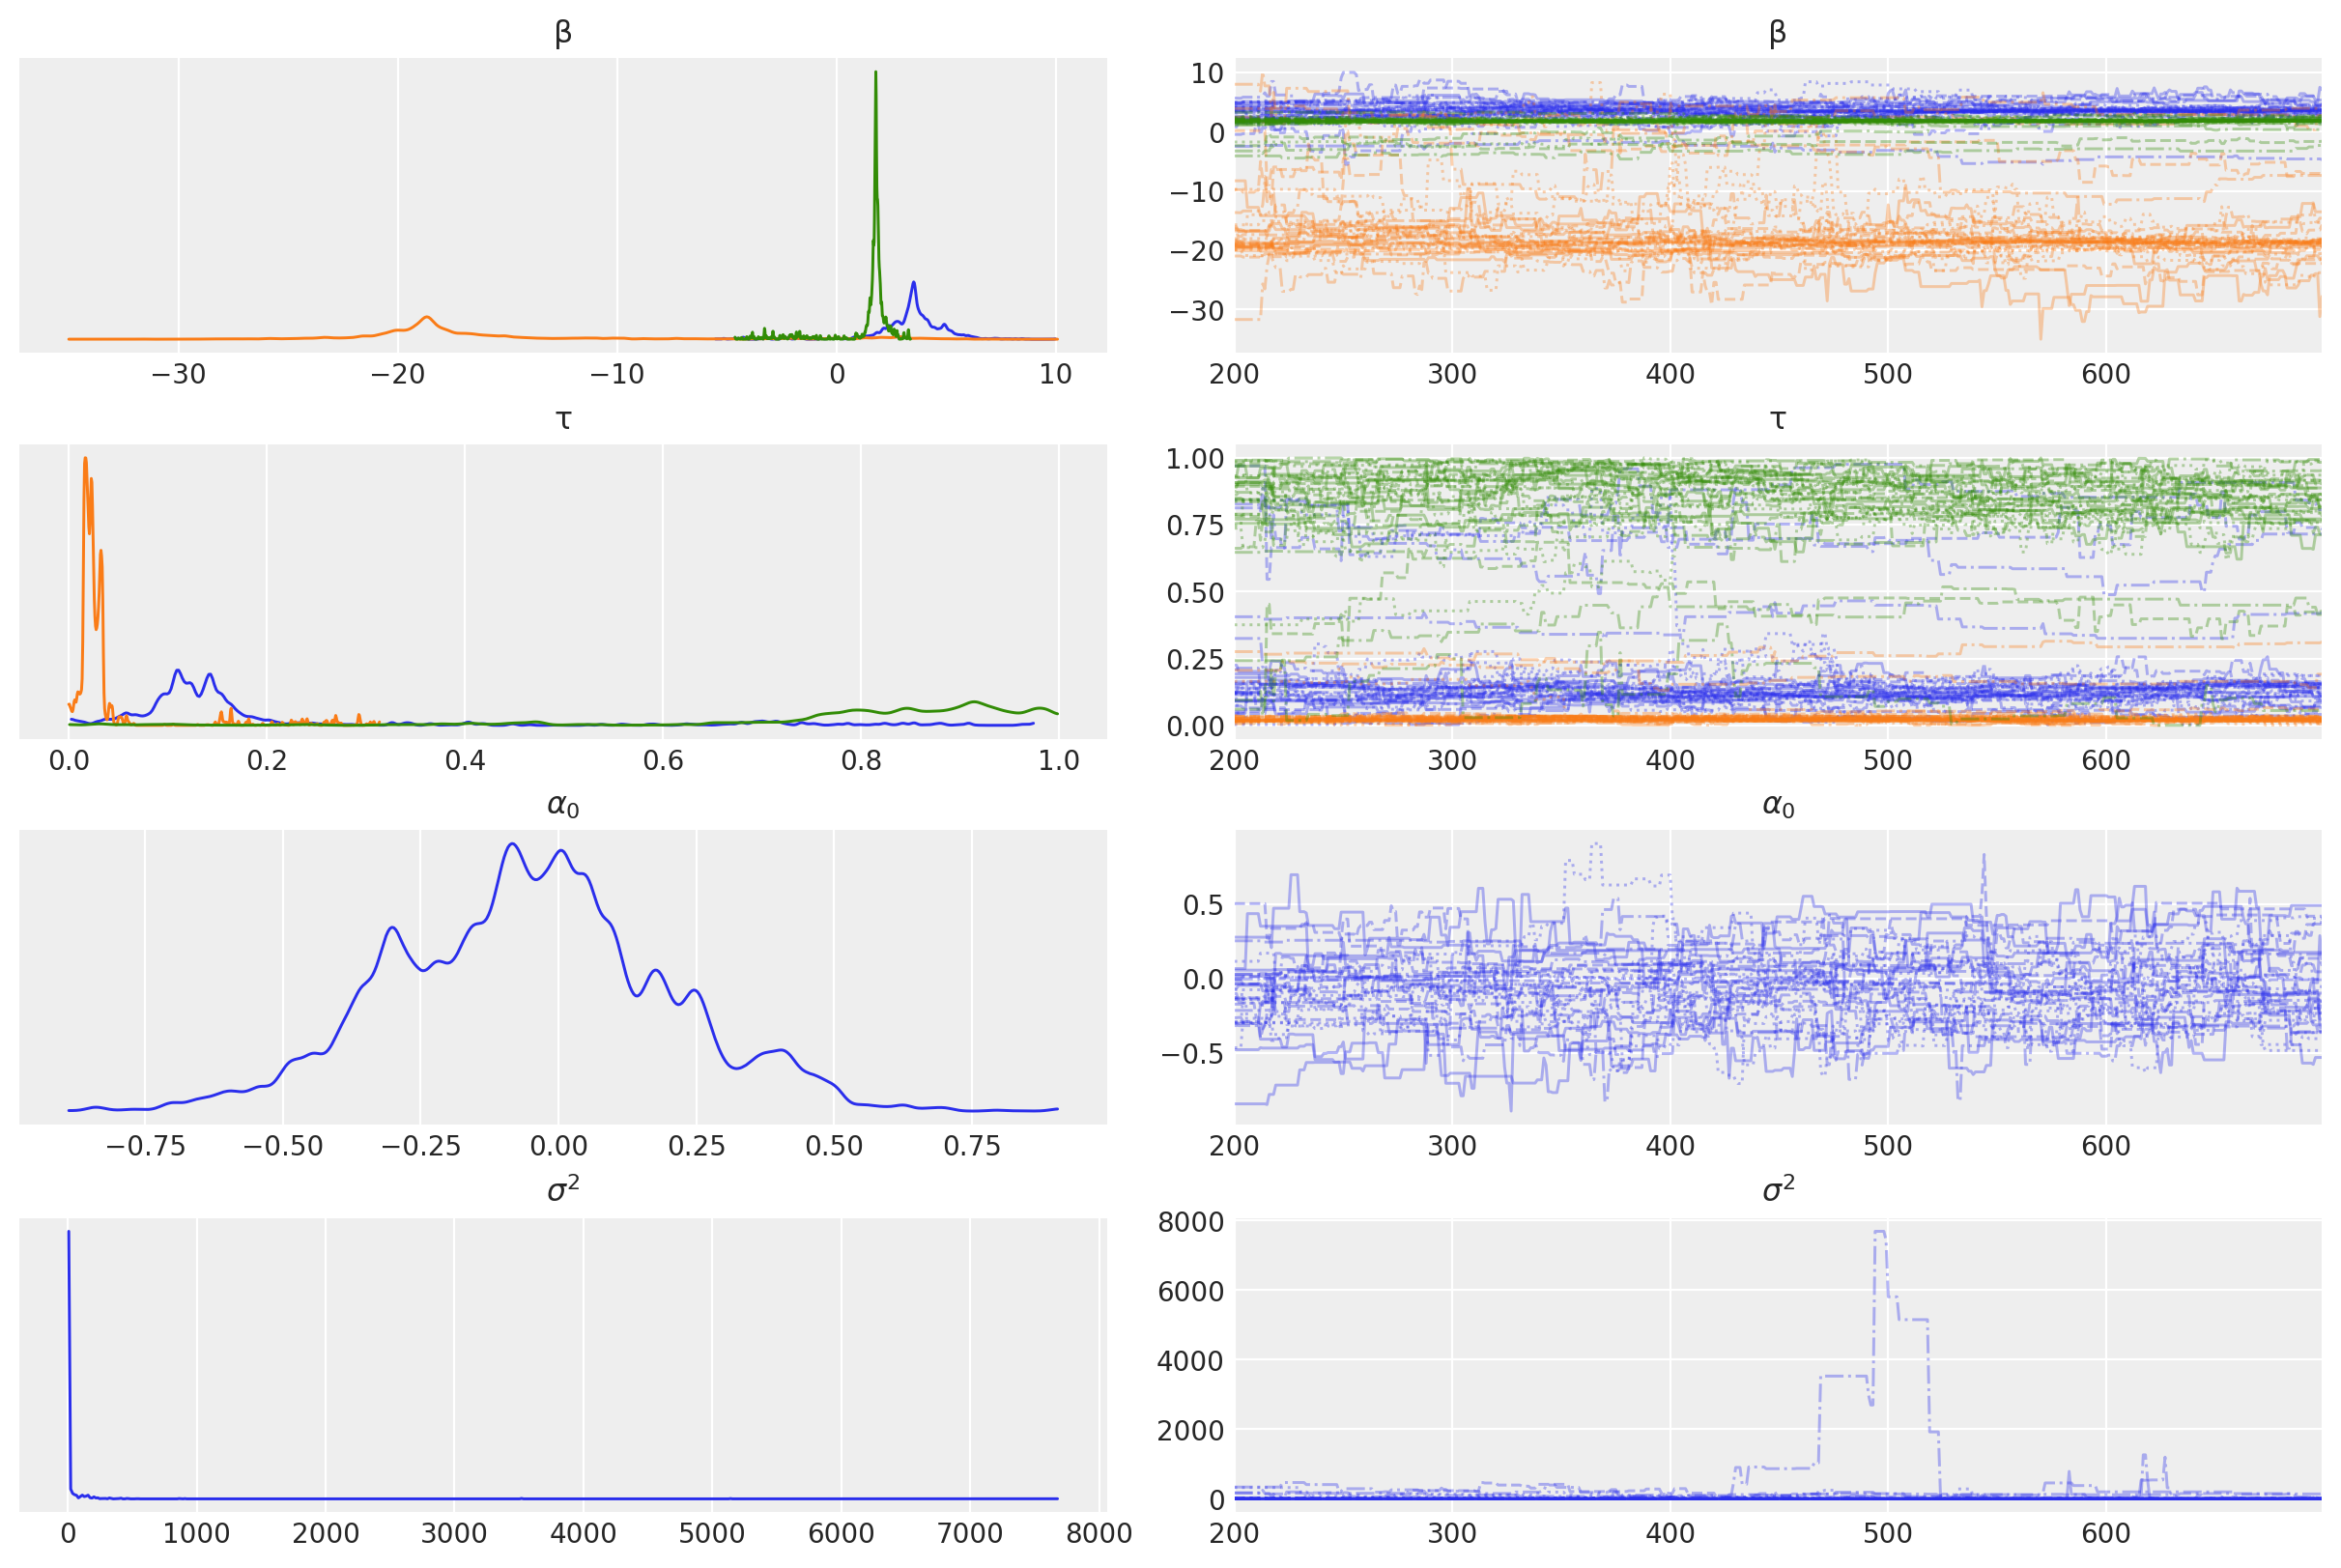

In [16]:
# -- Trace plot

az.plot_trace(
    idata_emcee,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)

print("Combined density and trace plot:")

Marginal posterior distributions:


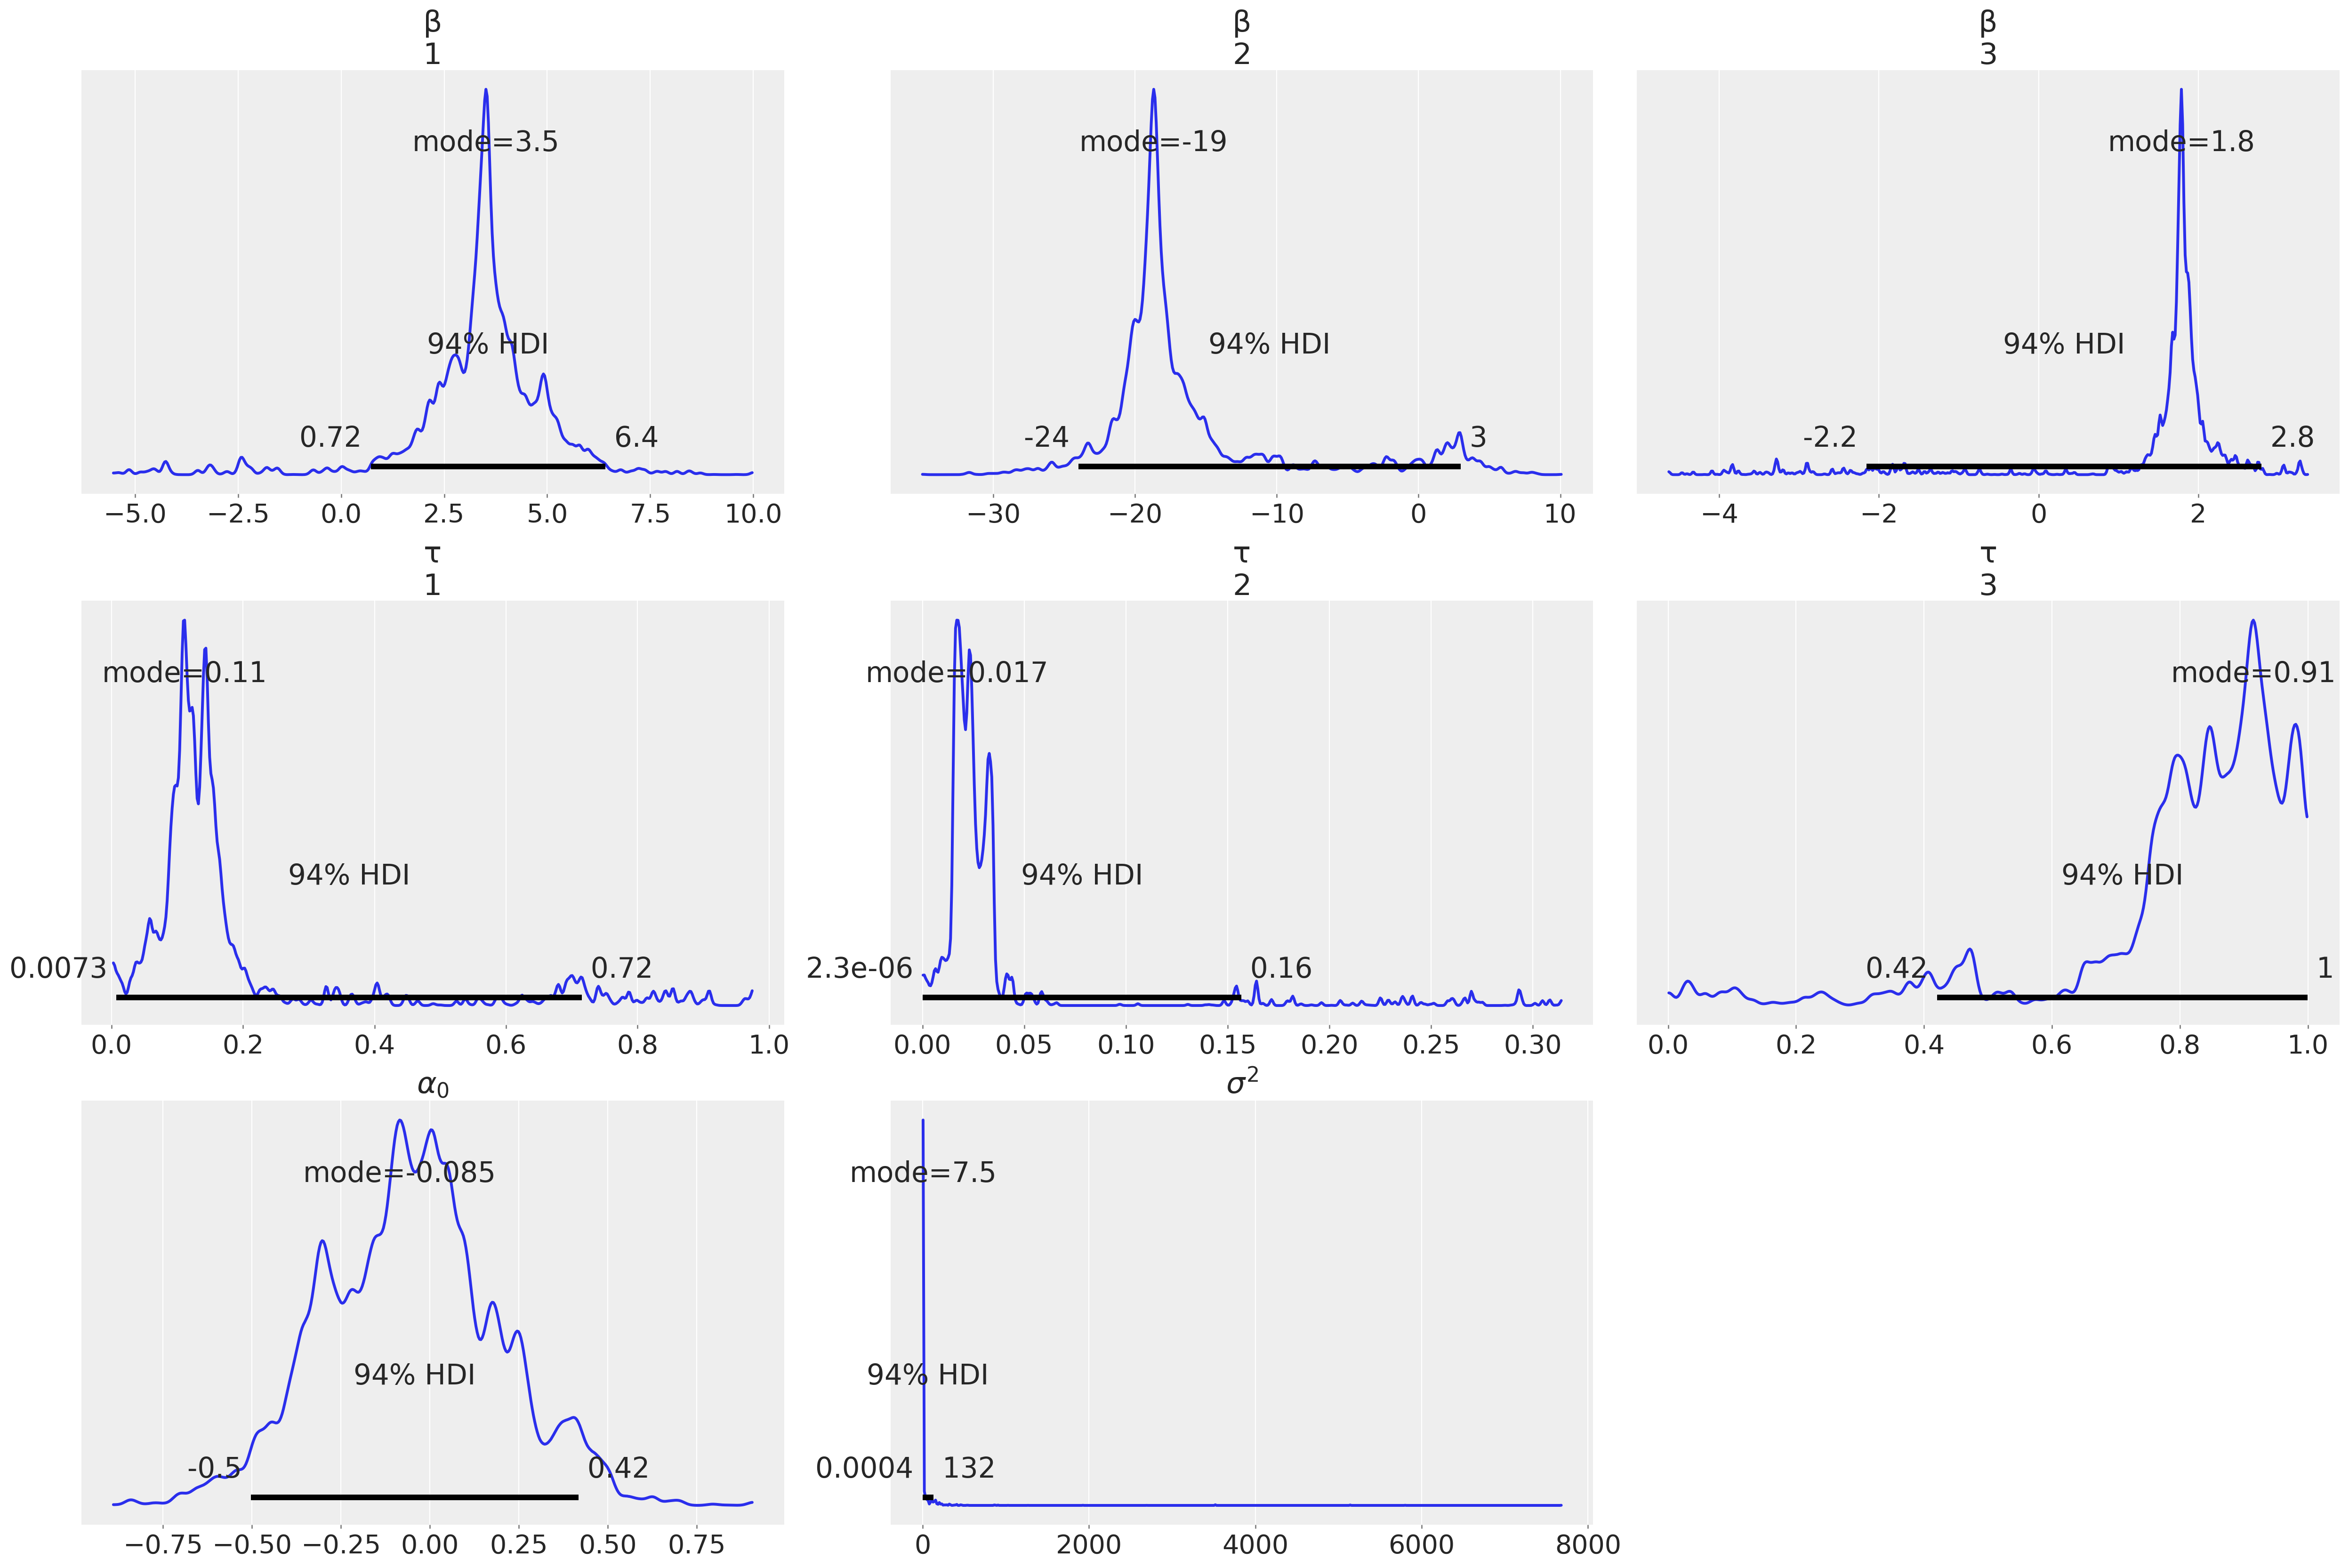

In [17]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

In this case, since the outcome variable is binary, we plot the distribution of $T(Y^*)$ to visually compare it with $T(Y)$, where $T$ is the number of $1$s in the sample (the number of successes). 

We also show a *separation plot*, in which the predicted probabilities $\hat p_i$ (suitably averaged for each chain and sample) are ordered in an ascending manner, and then a vertical line is drawn on each of them either in a dark color (if $y_i$ is 1) or a light color (if $y_i$ is 0). In a perfect model, all the dark lines would be on the rightmost part, effectively "separating" the samples.

Generating posterior predictive samples...
bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.501
bpv [T=mean]: 0.501
bpv [T=std]: 0.854


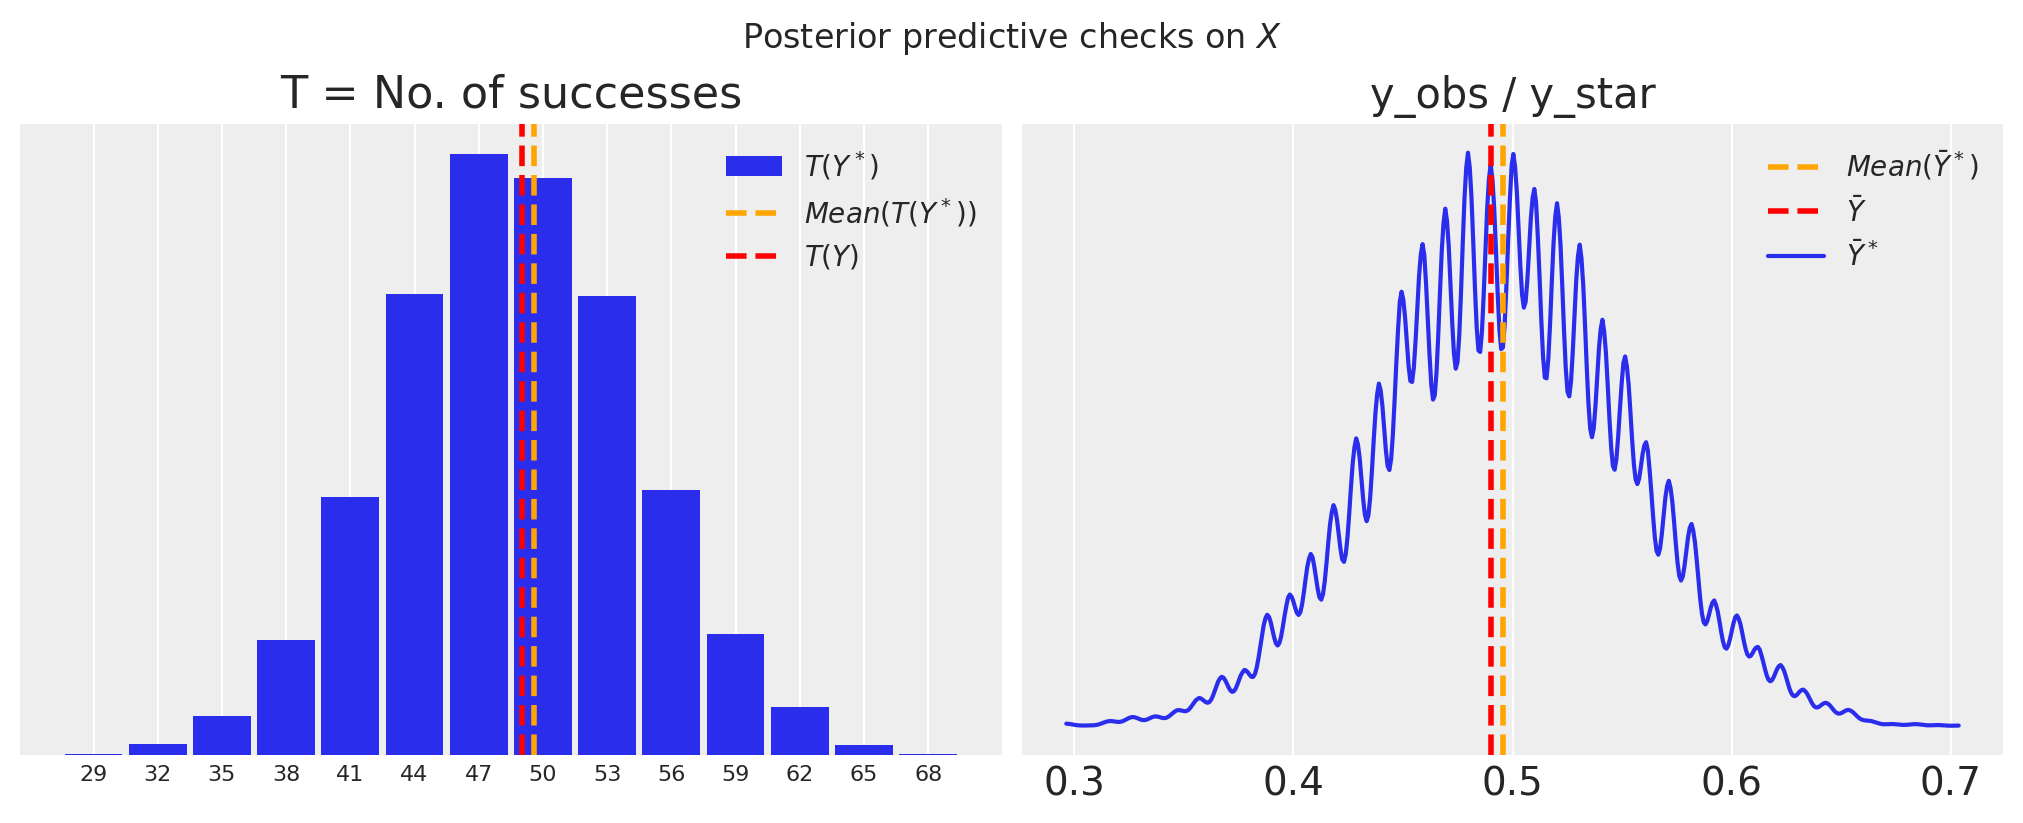

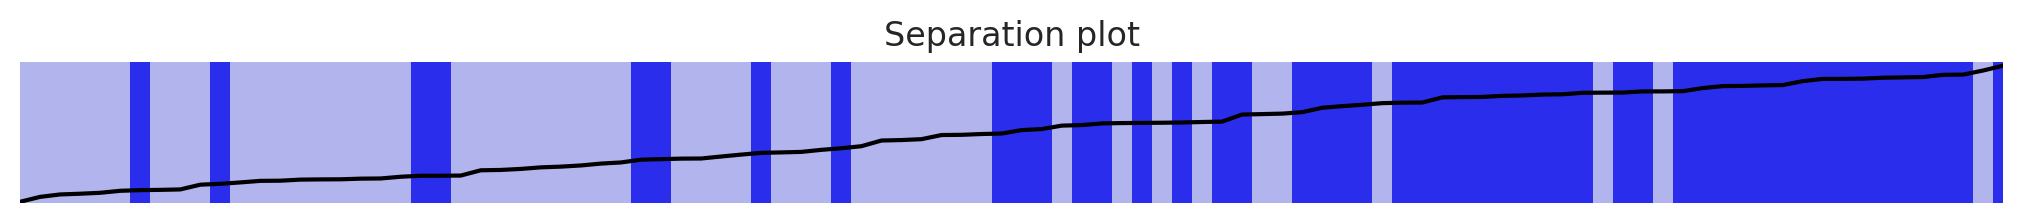

In [18]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp_p, pp_y = bayesian_model.generate_pp(
        idata_emcee, X, theta_space,
        kind='logistic', rng=rng, verbose=True)
    utils.pp_to_idata([pp_p, pp_y], idata_emcee,
                      ["p_star", "y_star"], merge=True)
else:
    pp_p = idata_emcee.posterior_predictive['p_star'].to_numpy()
    pp_y = idata_emcee.posterior_predictive['y_star'].to_numpy().astype(int)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_emcee, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_y, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


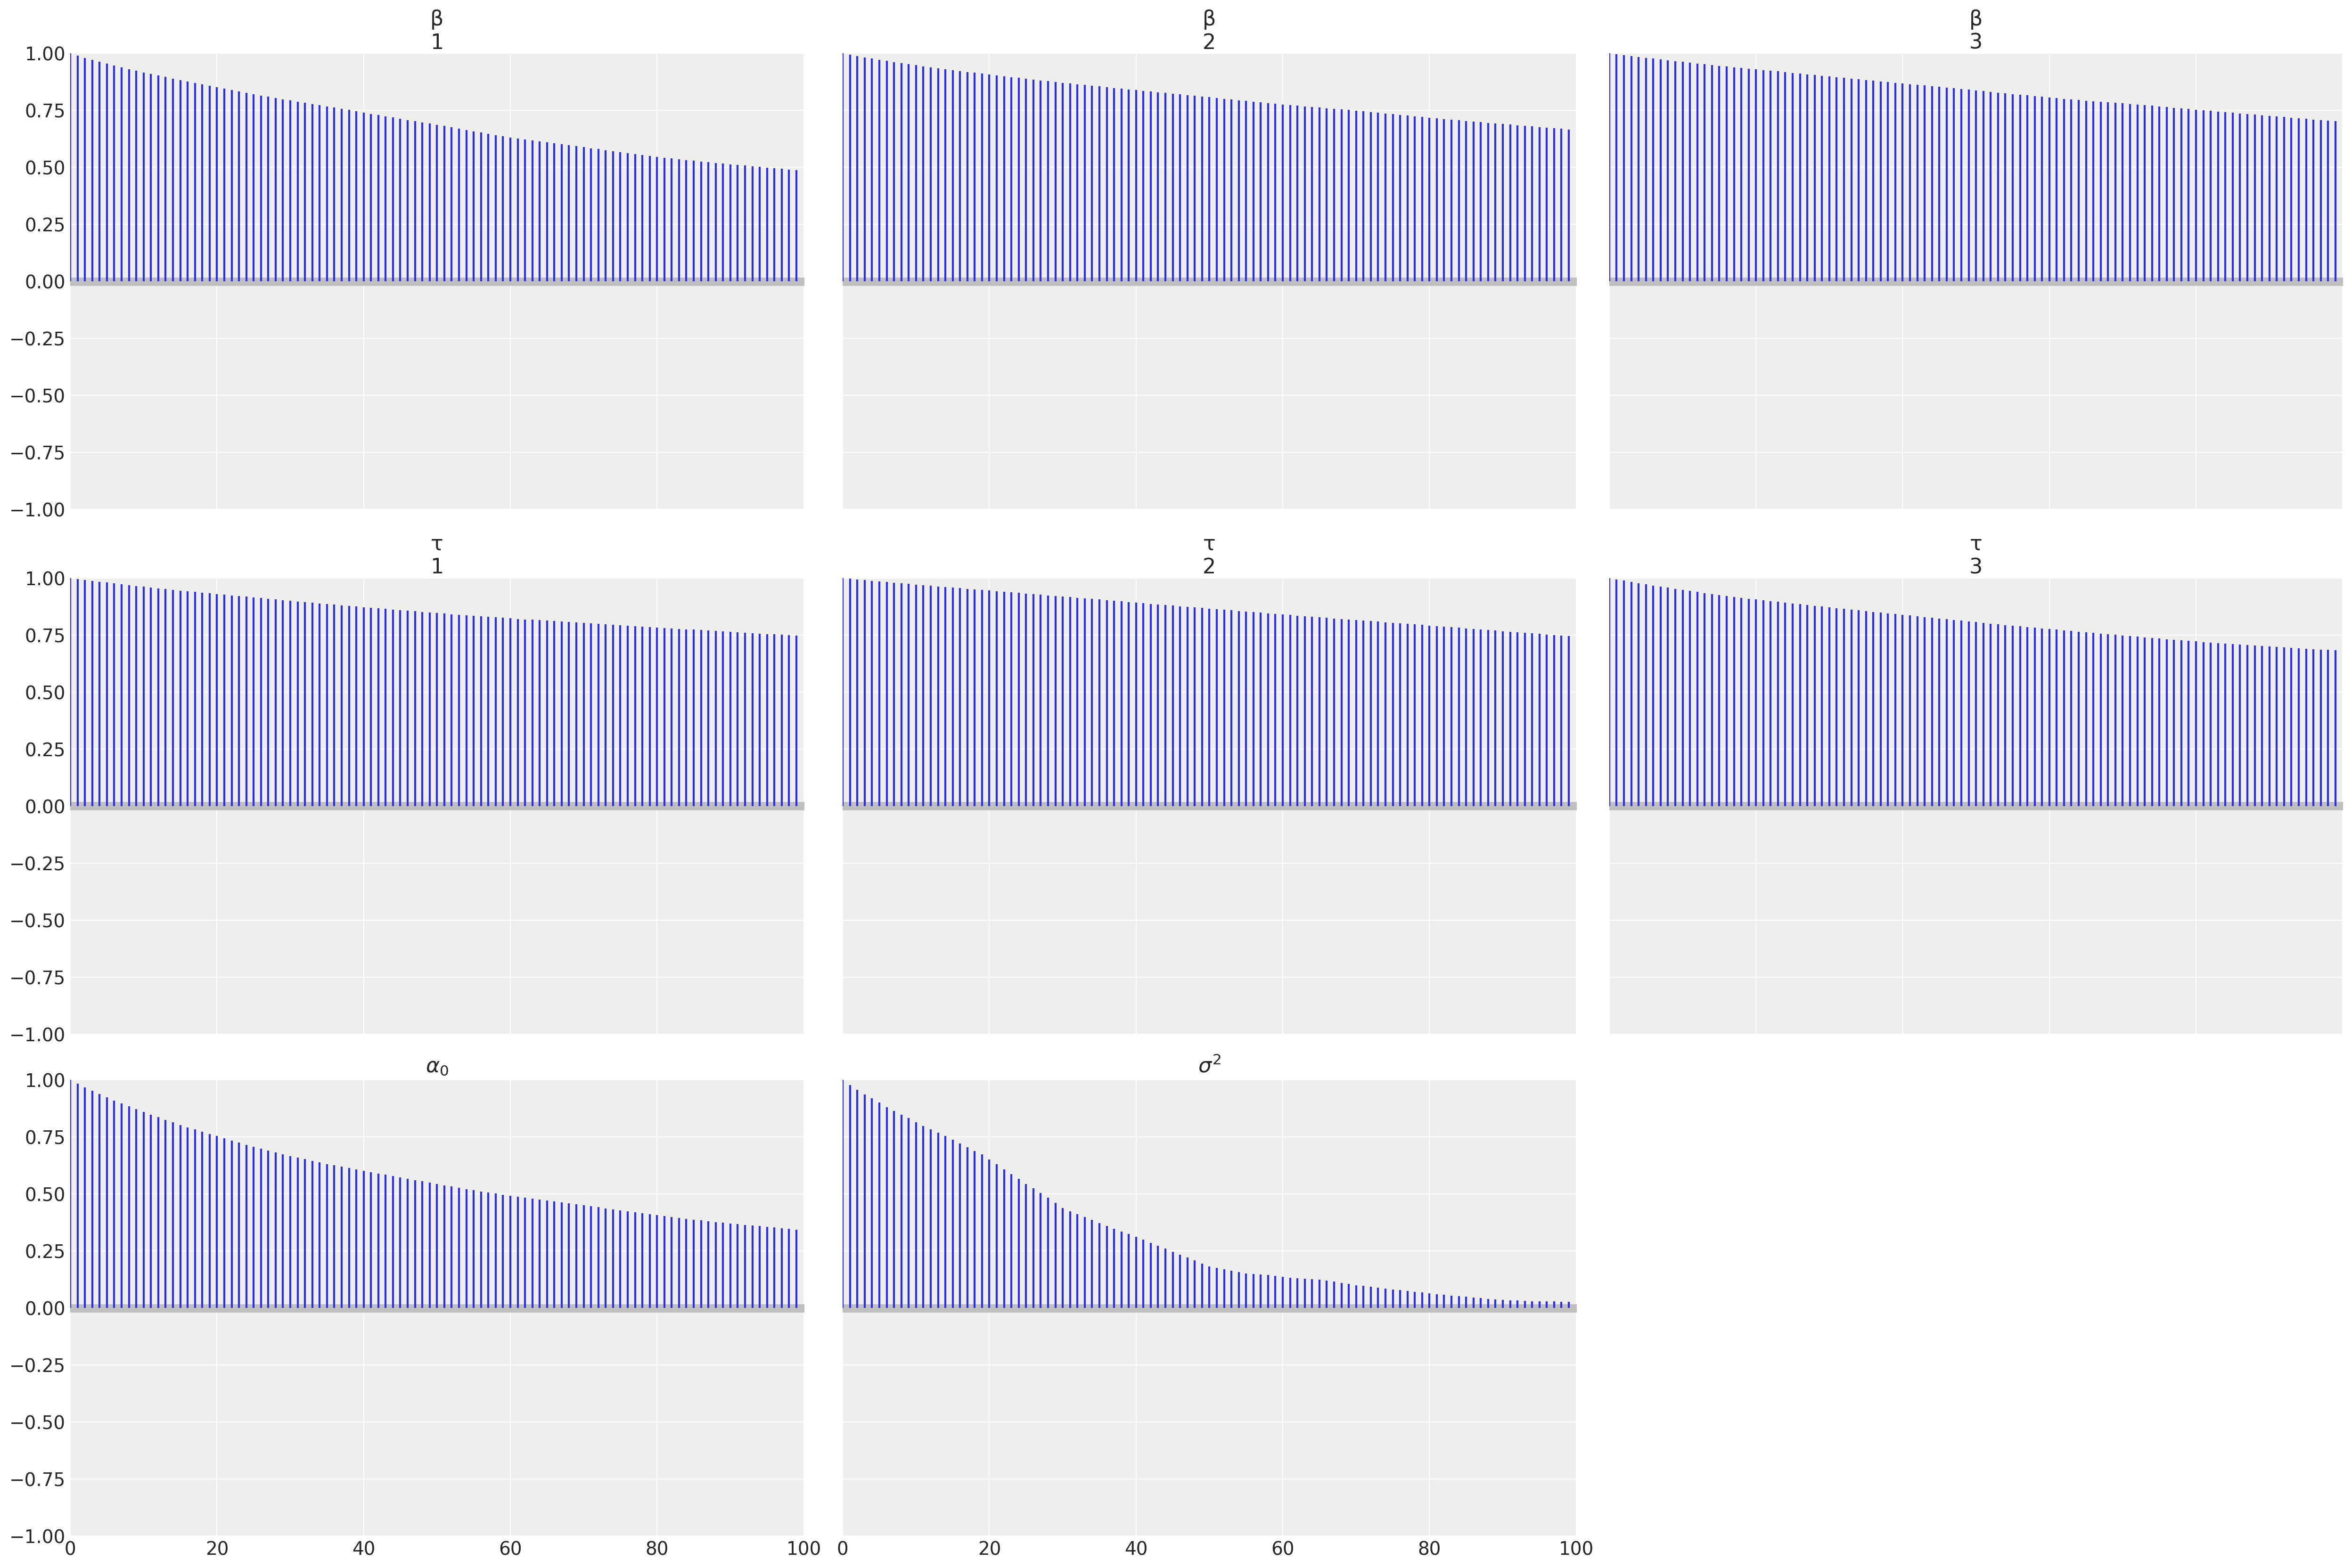

In [19]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

### Out-of-sample predictions

Generating posterior predictive samples...
bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.490
bpv [T=mean]: 0.490
bpv [T=std]: 1.000


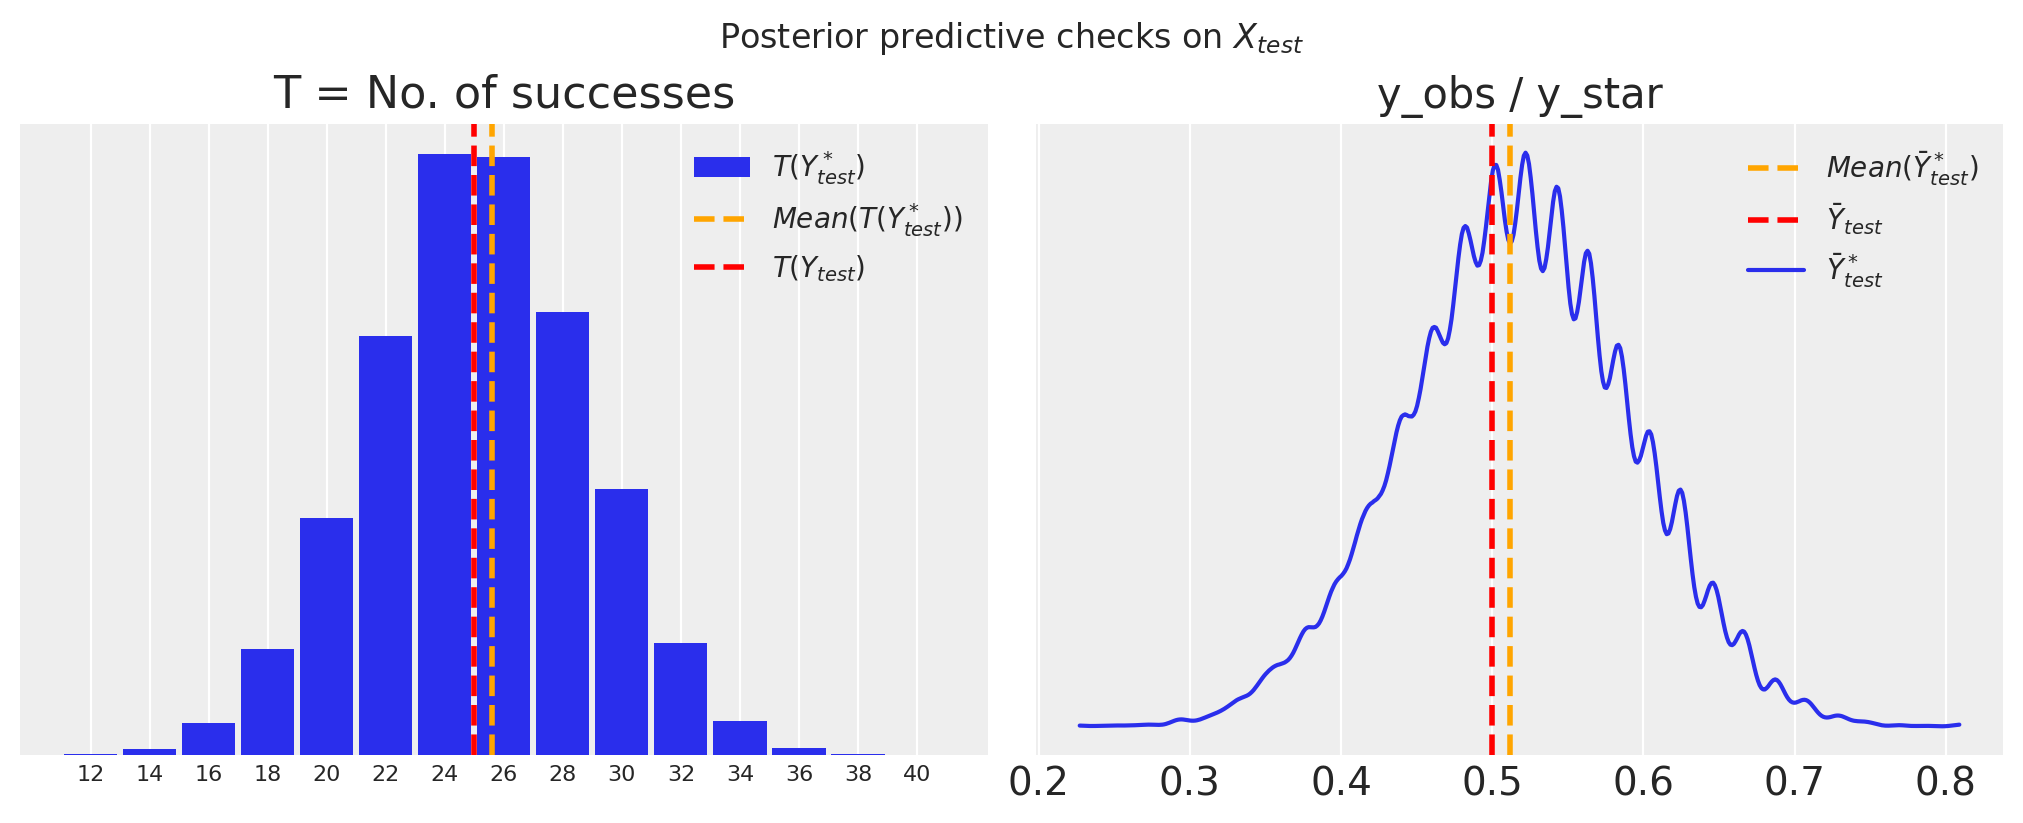

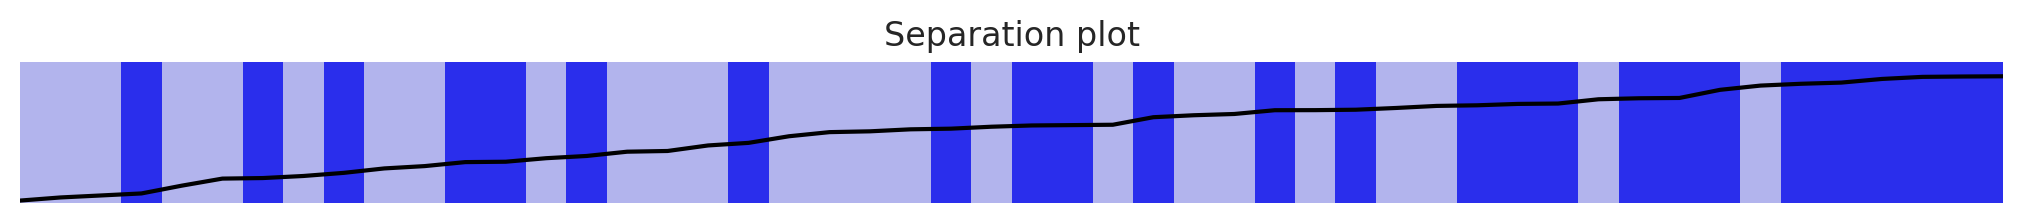

In [20]:
# -- Generate and plot posterior predictive samples from X_test

pp_test_p, pp_test_y = bayesian_model.generate_pp(
    idata_emcee, X_test, theta_space,
    rng=rng, kind='logistic', verbose=True)
idata_pp_test = utils.pp_to_idata(
    [pp_test_p, pp_test_y], idata_emcee, ["p_star", "y_star"], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test_y, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [21]:
# -- Compute metrics using several point estimates

df_metrics_emcee = None

# Posterior mean estimates
strategies = [("posterior_mean", pp_test_p), ("posterior_vote", pp_test_y)]
for name, pp in strategies:
    Y_pred_pp = [utils.apply_threshold(y)
                 for y in pp[:, ::thin_pp, :].mean(axis=(0, 1))]
    df_metrics_emcee = utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pp,
        clf_emcee.n_components(name),
        "emcee_" + name,
        df=df_metrics_emcee,
        sort_by=sort_by
    )

# Point estimates
for pe in clf_emcee.default_point_estimates:
    Y_pred_pe = clf_emcee.predict(X_test, strategy=pe)
    df_metrics_emcee = utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pe,
        clf_emcee.n_components(pe),
        "emcee_" + pe,
        df=df_metrics_emcee,
        sort_by=sort_by,
    )

df_metrics_emcee.style.hide(axis="index")

In [23]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = None

for pe in clf_emcee.default_point_estimates:
    X_red = clf_emcee.transform(X, pe=pe)
    X_test_red = clf_emcee.transform(X_test, pe=pe)

    df_metrics_emcee_var_sel = utils.multiple_logistic_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        pe=pe,
        df=df_metrics_emcee_var_sel,
        random_state=SEED
    )

df_metrics_emcee_var_sel.style.hide(axis="index")

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [ ]:
# -- Save

with open("emcee-logistic.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [ ]:
# -- Load

with open("emcee-logistic.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

**TODO (v4)**

- Change imports pymc3 -> pymc; theano.tensor -> aesara.tensor
- Try beta = MvNormal
- Try symbolic shape (e.g. tau.shape == p)
- Measure execution times of new pm.sample_posterior_predictive (X should be MutableData (and changed for X_test) for ppc in test set).
- Si beta acaba siendo DensityDist, medir tiempos con y sin parámetros en beta_logp
- Definir adecuadamente los valores iniciales (initval) en p, para que haya al menos uno en cada cadena.
- Añadir random a beta para poder samplear de ella.
- Cambiar start=.. por initvals=... en pm.sample()
- Probar Sequential Monte Carlo
- Probar jax_sampling

In [4]:
from bfr.mcmc_sampler import BFLogisticPymc
import pymc as pm

### Experiments

In [36]:
# -- Sampler parameters

n_chains = N_CORES
USE_NUTS = False

if USE_NUTS:
    n_samples = 500
    n_tune = 500
    step_fn = pm.NUTS
    step_kwargs = {"target_accept": 0.8}
else:
    n_samples = 500
    n_tune = 100
    step_fn = pm.Metropolis
    step_kwargs = {}

burn = 0
thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [37]:
# -- Run sampler

print(f"-- Running pymc sampler with {N_CORES} cores --")

clf_pymc = BFLogisticPymc(
    theta_space,
    n_chains,
    n_samples,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    step_fn=step_fn,
    step_kwargs=step_kwargs,
    n_iter_warmup=n_tune,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    random_state=SEED
)

if FAST_RUN:
    df_metrics_pymc = utils.run_bayesian_model(
        clf_pymc,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='logistic',
        prefix='pymc',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        sort_by=sort_by,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE:
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_mle])
        if FIT_SK:
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_sk])

        df_metrics_pymc.sort_values(
            df_metrics_pymc.columns[sort_by],
            inplace=True,
            ascending=False
        )
        display(df_metrics_pymc.style.hide(axis="index"))
else:
    clf_pymc.fit(X, Y)
    print(f"Mean acceptance: {100*reg_pymc.mean_acceptance():.3f}%")

idata_pymc = clf_pymc.get_idata()

-- Running pymc sampler with 4 cores --
[BFLogisticPymc] Computing MLE...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [β]
>Metropolis: [τ]
>Metropolis: [α0_and_LogSq σ2]


Sampling 4 chains for 100 tune and 500 draw iterations (400 + 2_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


[BFLogisticPymc] Discarding the first 0 samples...
Mean acceptance: 21.833%


mean         sd  hdi_3%    hdi_97%     min         max  \
β[1]          -1.771      3.165  -8.288      3.304 -10.902       5.218   
β[2]           2.810      2.530  -1.435      7.898  -4.398       9.527   
β[3]           1.092      3.243  -5.053      6.638  -7.636       9.307   
τ[1]           0.486      0.239   0.049      0.900   0.001       0.978   
τ[2]           0.538      0.302   0.131      0.980   0.030       0.999   
τ[3]           0.657      0.269   0.150      0.997   0.002       0.997   
$\alpha_0$    -0.063      0.262  -0.532      0.404  -0.868       0.698   
$\sigma^2$  3258.061  10751.507  97.466  10119.703  90.574  128867.969   

              median     mode  
β[1]          -1.415   -0.905  
β[2]           2.335    2.116  
β[3]           1.460    1.547  
τ[1]           0.479    0.489  
τ[2]           0.616    0.152  
τ[3]           0.677    0.994  
$\alpha_0$    -0.059   -0.221  
$\sigma^2$  1040.507  216.333


Computing metrics...

Generating posterior predictive samples...
Generating posterior predictive samples...


### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [27]:
# -- Trace summary

clf_pymc.summary(stats='all')

arviz - WARNING - Array contains NaN-value.


mean         sd  hdi_3%     hdi_97%   mcse_mean     mcse_sd  \
p           1.586e+00  7.500e-01   1.000       3.000       0.326       0.248   
β[1]        7.080e-01  2.095e+00  -3.841       3.063       0.787       0.581   
β[2]        8.570e-01  3.494e+00  -3.829       6.737         NaN         NaN   
β[3]        3.013e+00  1.375e+00   1.043       5.632         NaN         NaN   
τ[1]        6.880e-01  2.560e-01   0.134       0.997       0.092       0.068   
τ[2]        6.760e-01  2.450e-01   0.239       0.996         NaN         NaN   
τ[3]        7.990e-01  1.250e-01   0.602       0.956         NaN         NaN   
$\alpha_0$ -7.500e-02  2.710e-01  -0.535       0.460       0.019       0.015   
$\sigma^2$  1.150e+06  8.238e+06  46.491  878281.623  806307.840  571746.515   

            ess_bulk  ess_tail  r_hat     min        max    median       mode  
p                5.0       6.0   2.14   1.000  3.000e+00     1.000      1.000  
β[1]             8.0      42.0   1.41  -6.307  4.832e+00     1.622      1.928  
β[2]             NaN       NaN    NaN -17.785  7.595e+00     1.112     -1.055  
β[3]             NaN       NaN    NaN   0.149  6.487e+00     2.931      1.727  
τ[1]            11.0      48.0   1.30   0.017  9.970e-01     0.776      0.898  
τ[2]             NaN       NaN    NaN   0.007  9.960e-01     0.731      0.893  
τ[3]             NaN       NaN    NaN   0.166  9.730e-01     0.820      0.903  
$\alpha_0$     214.0     194.0   1.02  -0.914  8.010e-01    -0.048      0.026  
$\sigma^2$      12.0      53.0   1.30  46.491  9.868e+07  5186.541  96414.772

Combined density and trace plot:


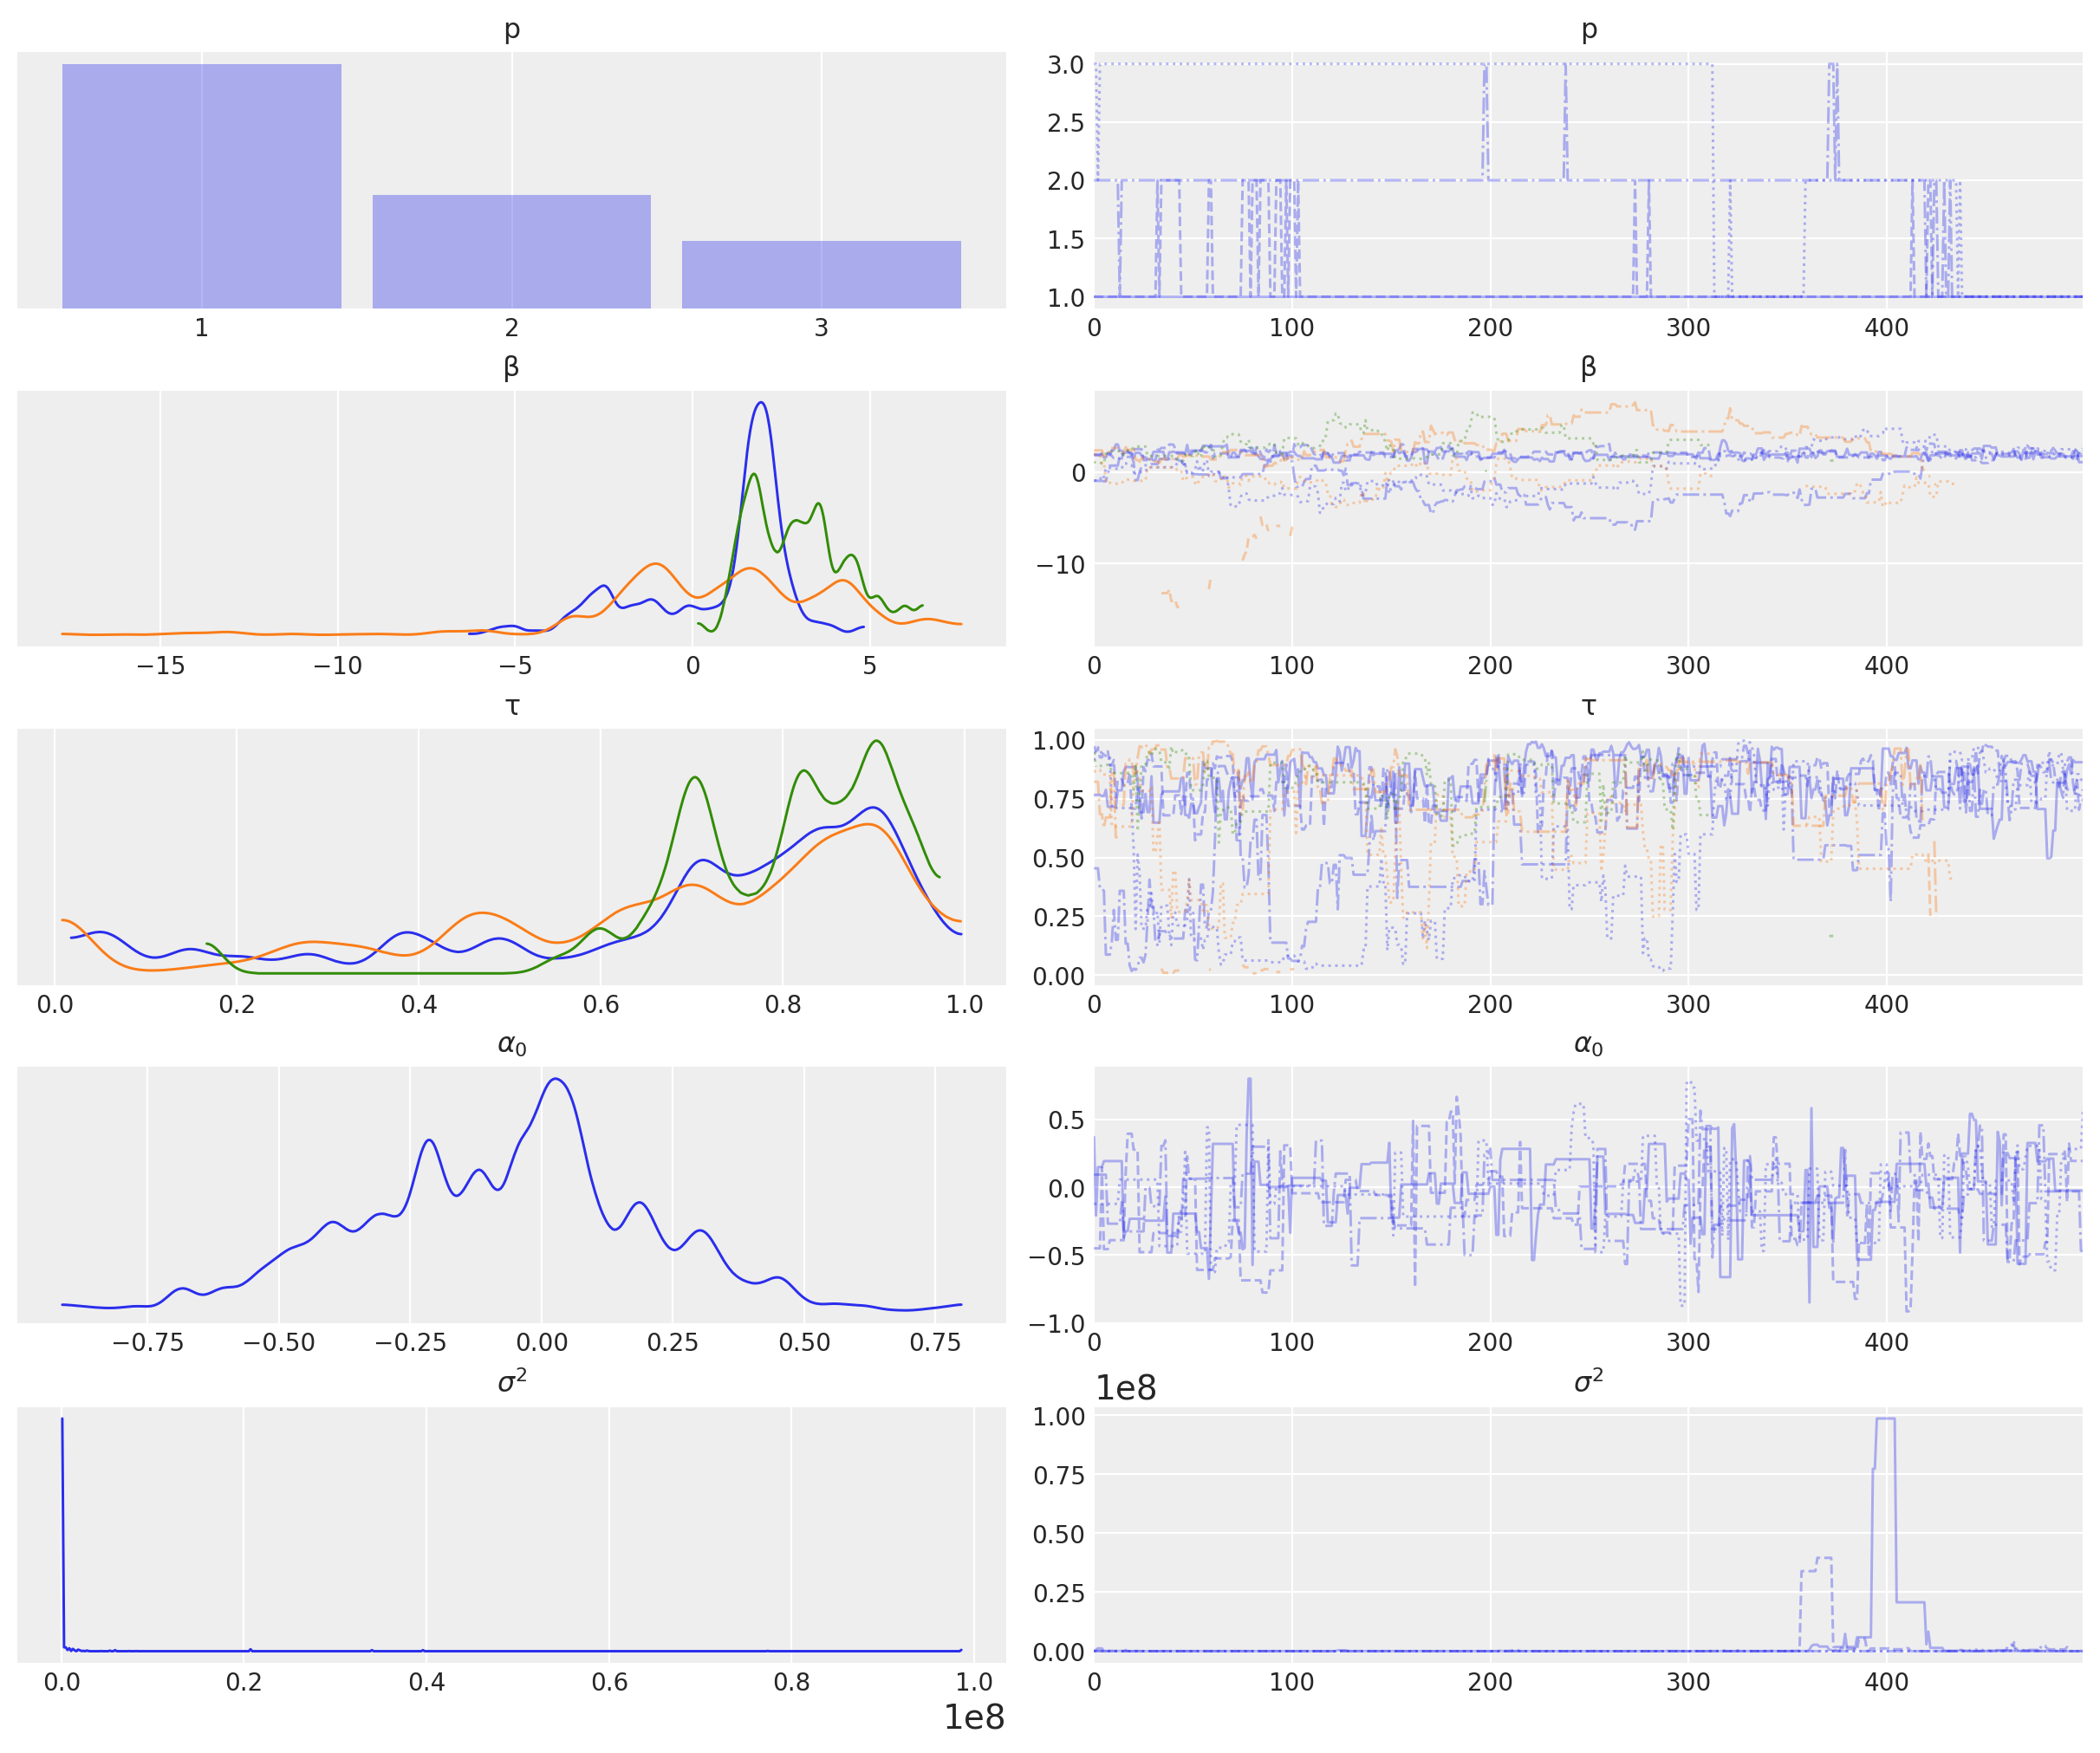

In [28]:
# -- Trace plot

az.plot_trace(
    idata_pymc,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)
print("Combined density and trace plot:")

Marginal posterior distributions:


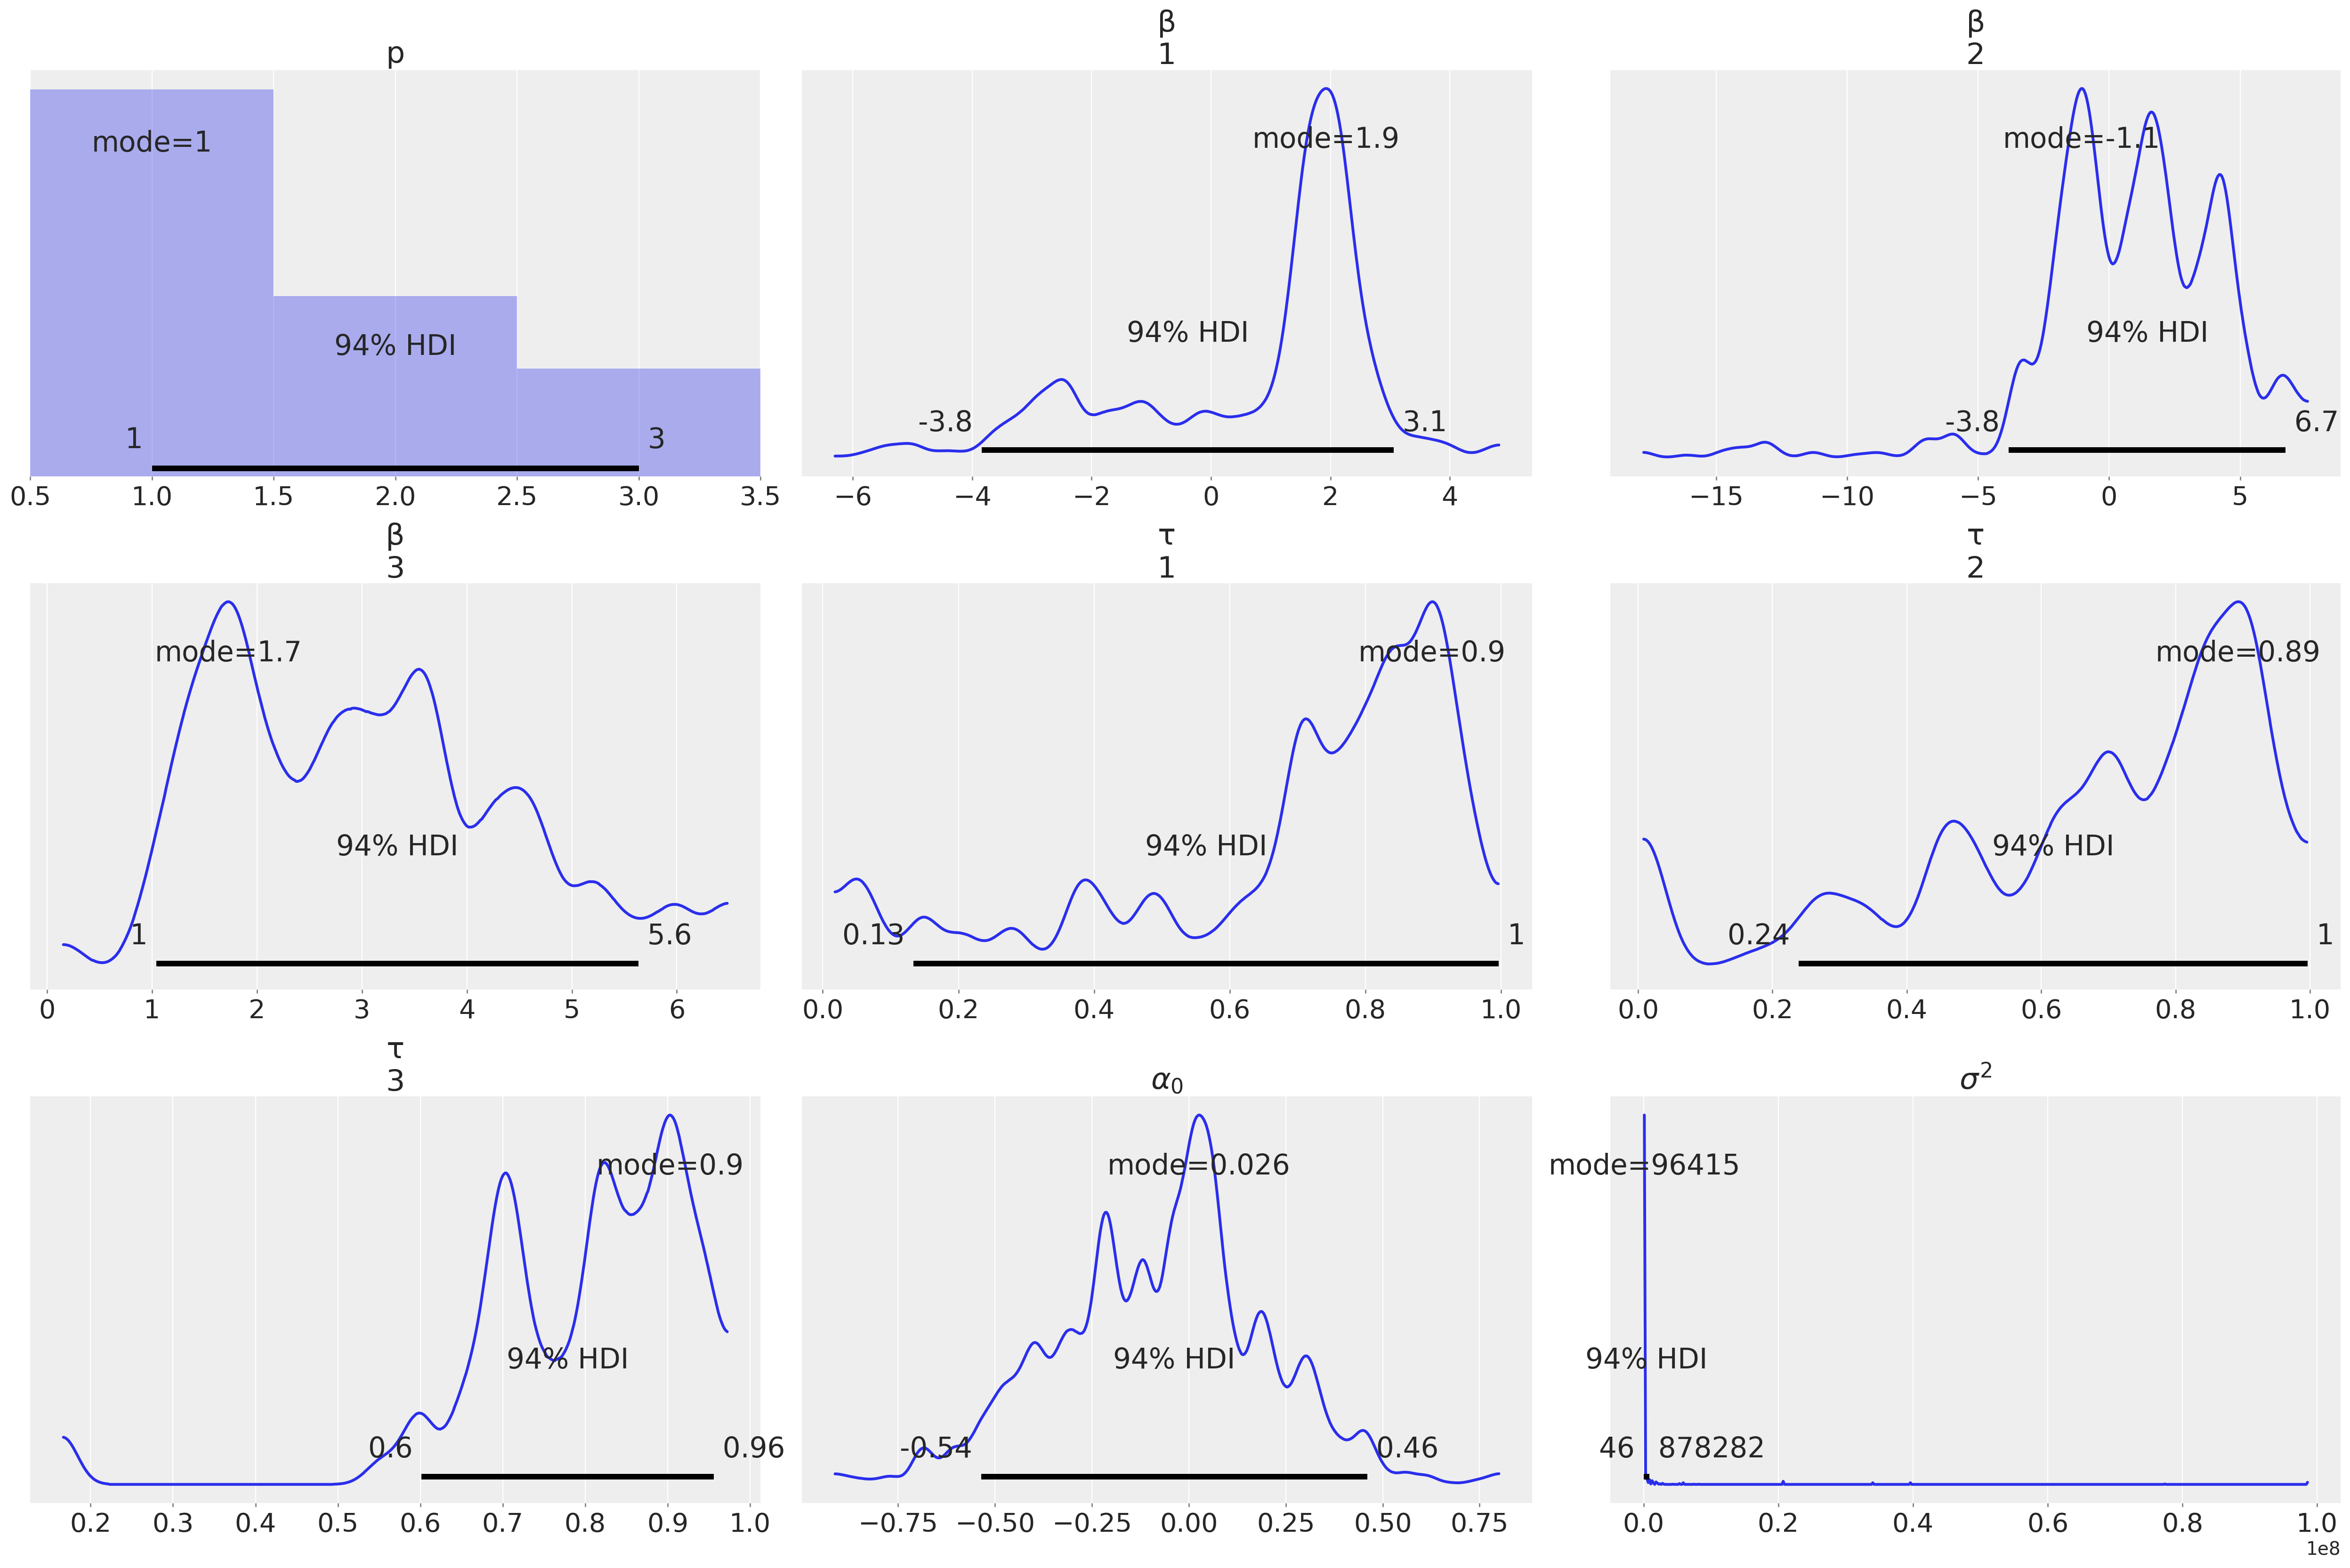

In [29]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Generating posterior predictive samples...
bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.542
bpv [T=mean]: 0.542
bpv [T=std]: 0.862


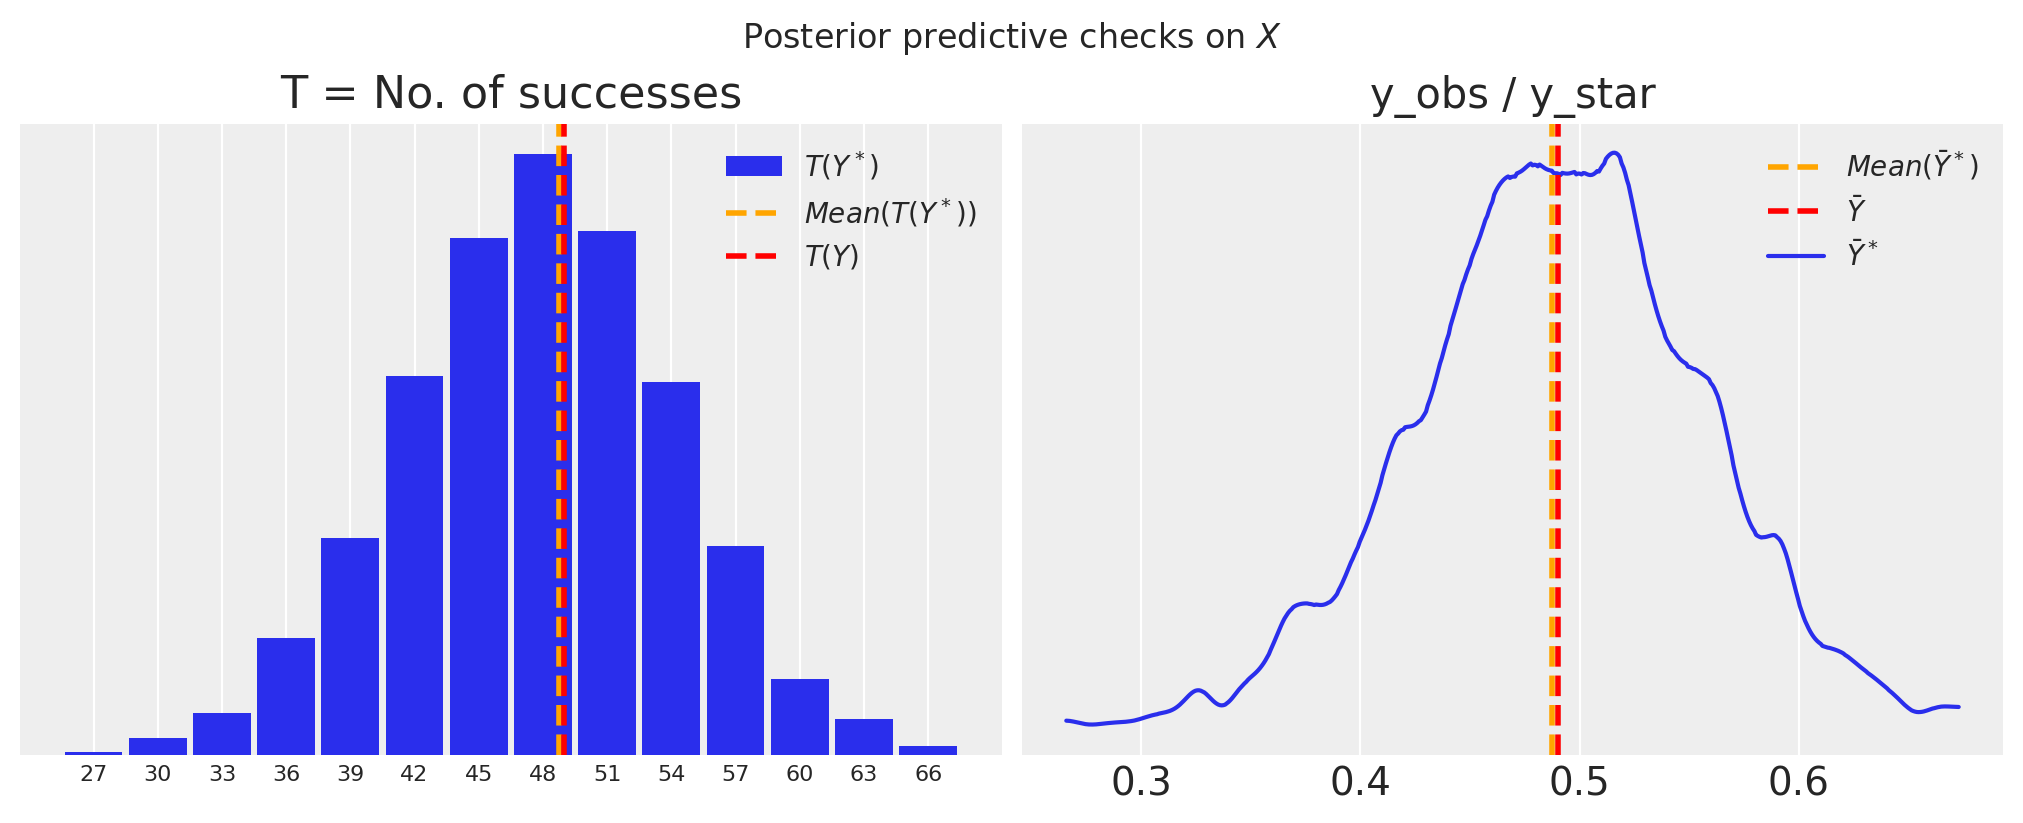

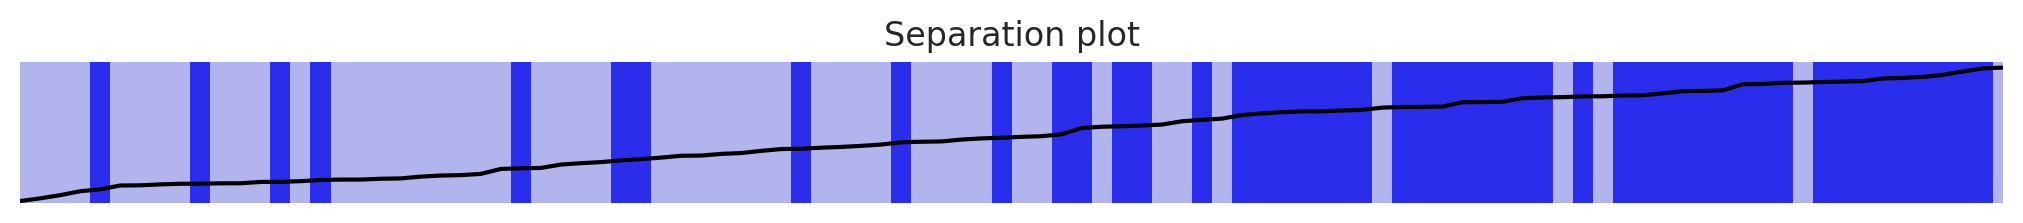

In [30]:
# -- Generate and plot posterior predictive samples from X

pp_p, pp_y = bayesian_model.generate_pp(
    idata_pymc, X, theta_space,
    rng=rng, kind='logistic', verbose=True)
utils.pp_to_idata(
    [pp_p, pp_y], idata_pymc, ['p_star', 'y_star'], merge=True)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_pymc, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_y, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


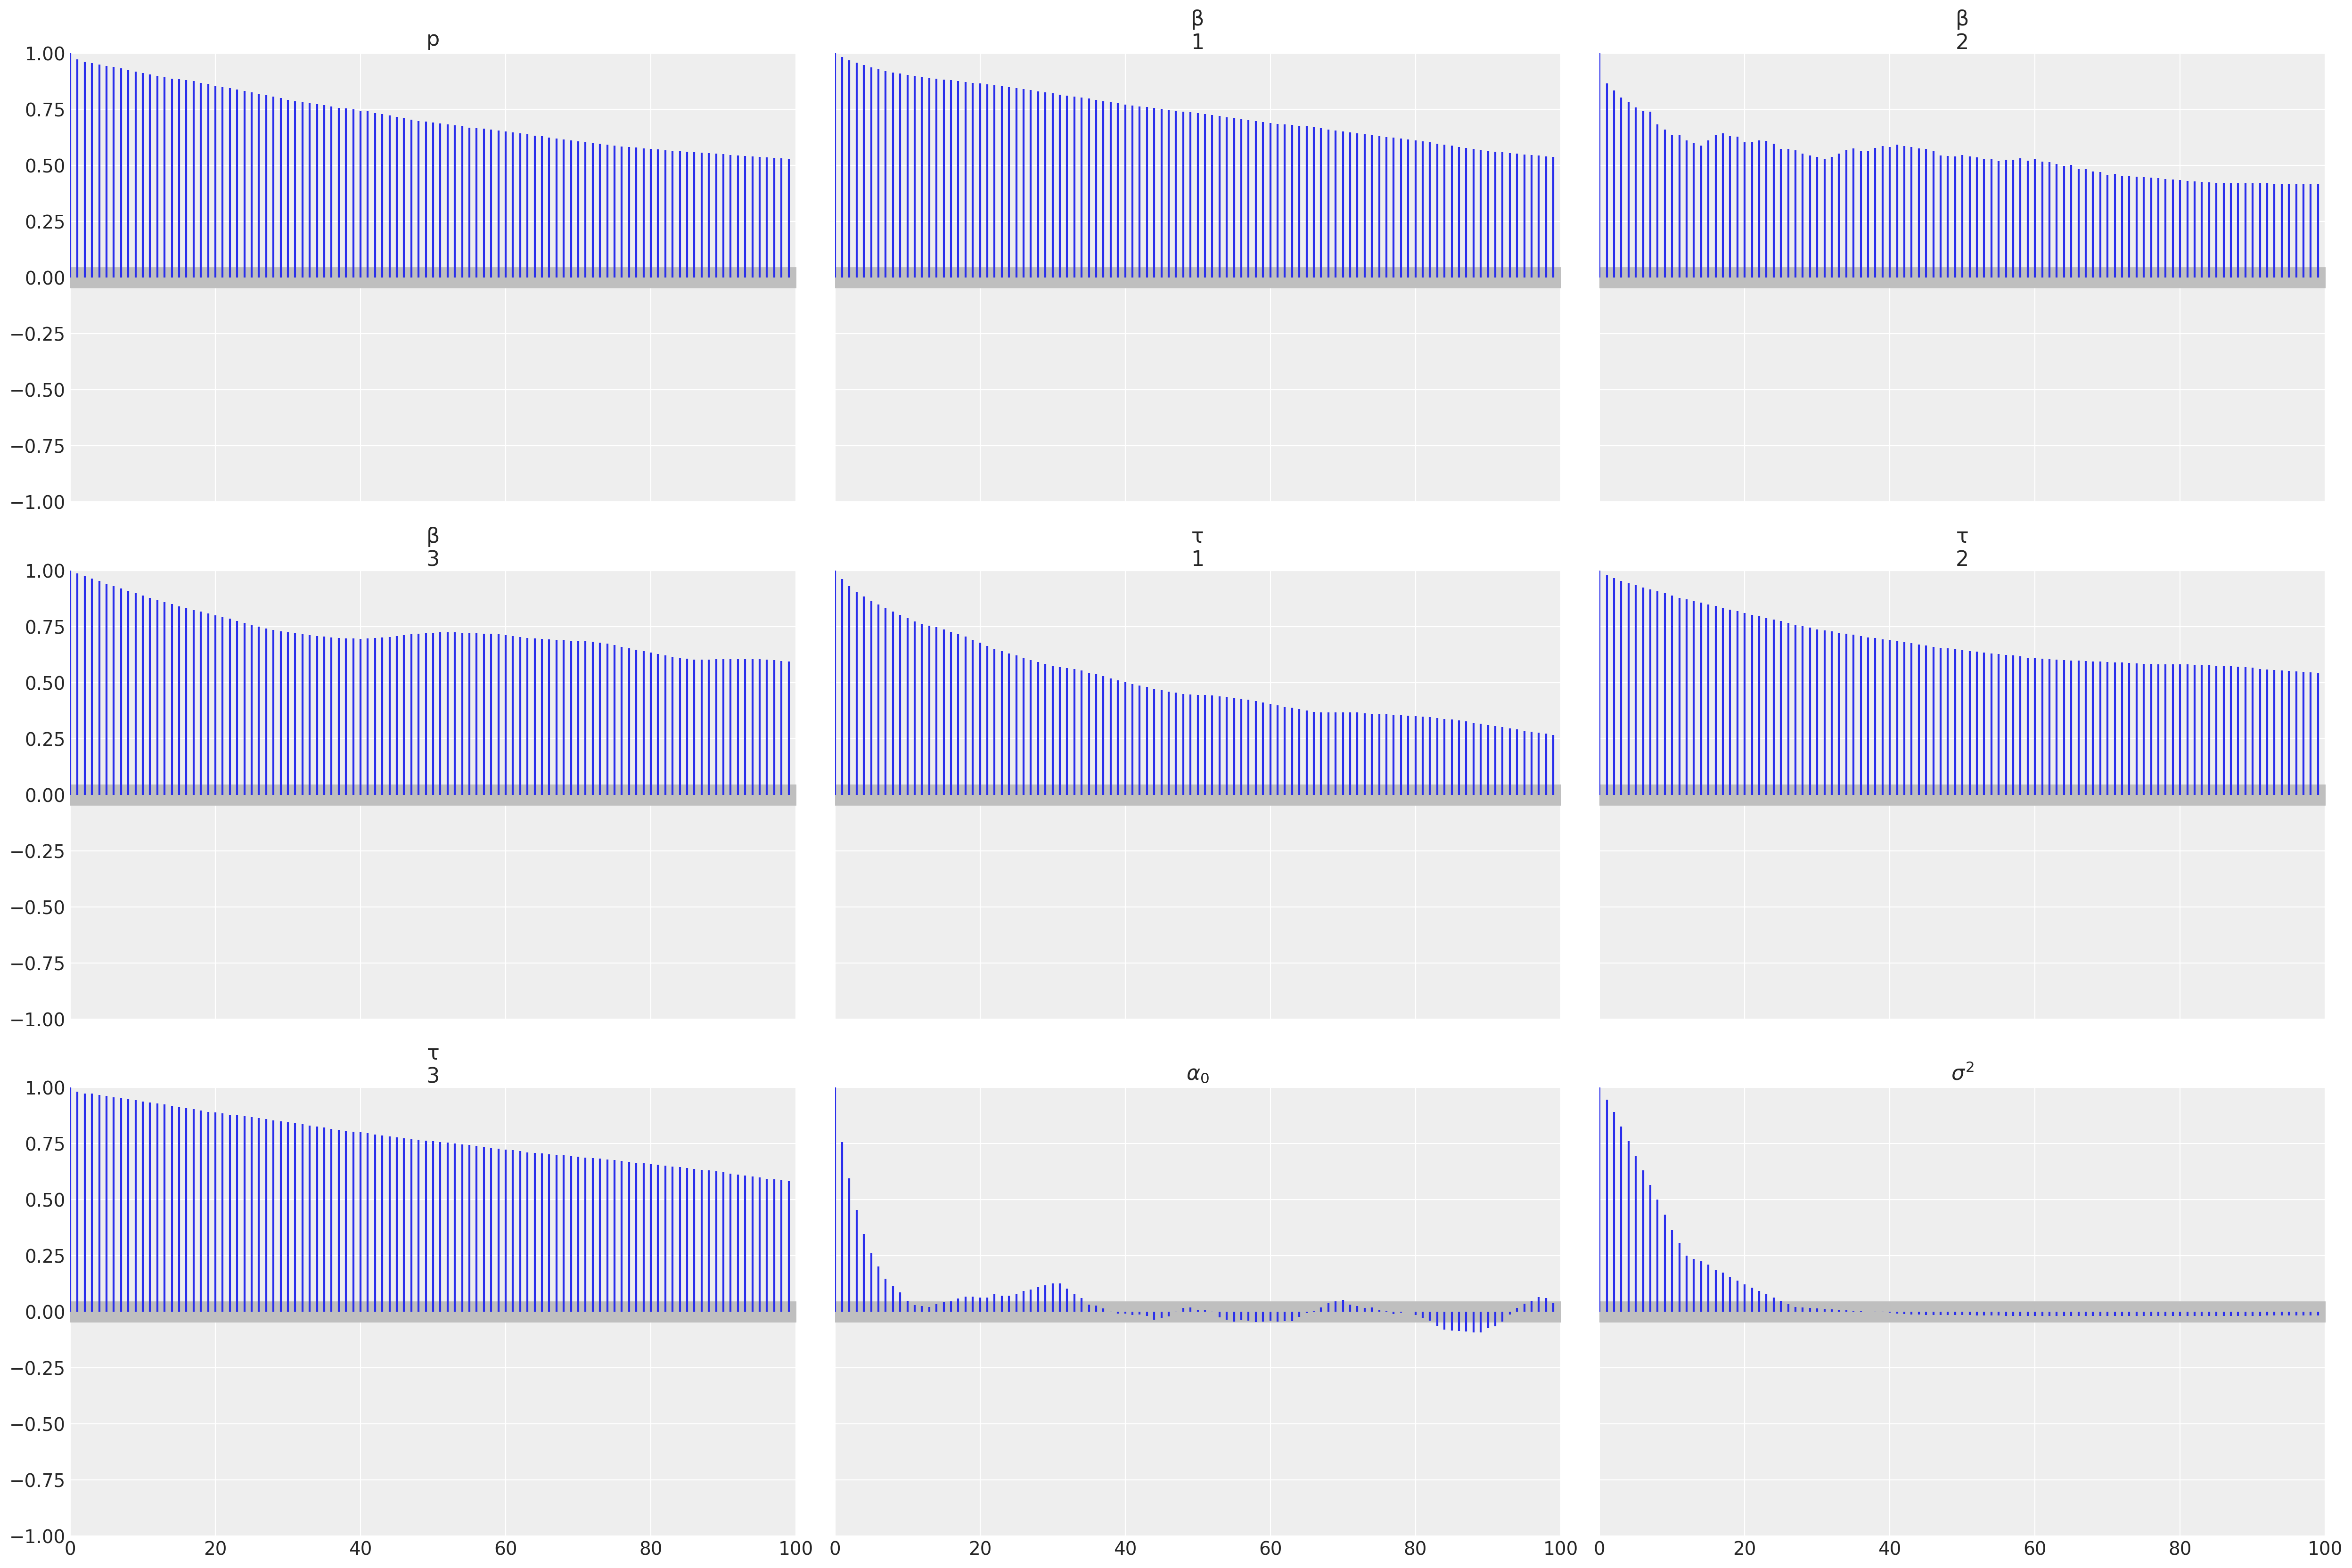

In [31]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

Graphical model:


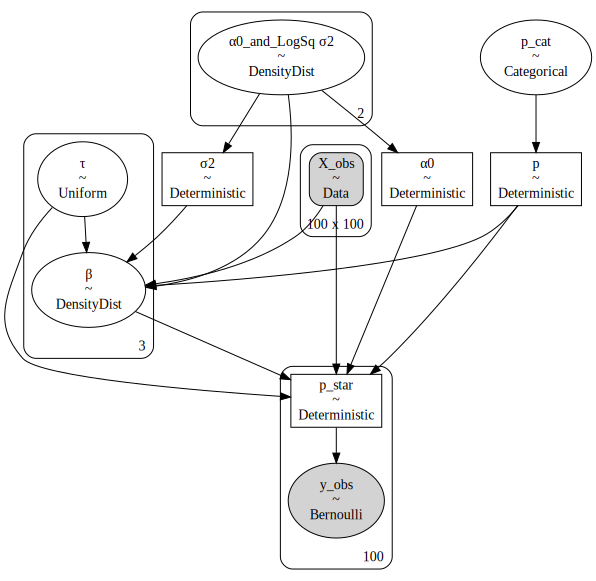

In [32]:
# -- Graphical model

print("Graphical model:")
clf_pymc.to_graphviz()

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive samples...
bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.492
bpv [T=mean]: 0.492
bpv [T=std]: 1.000


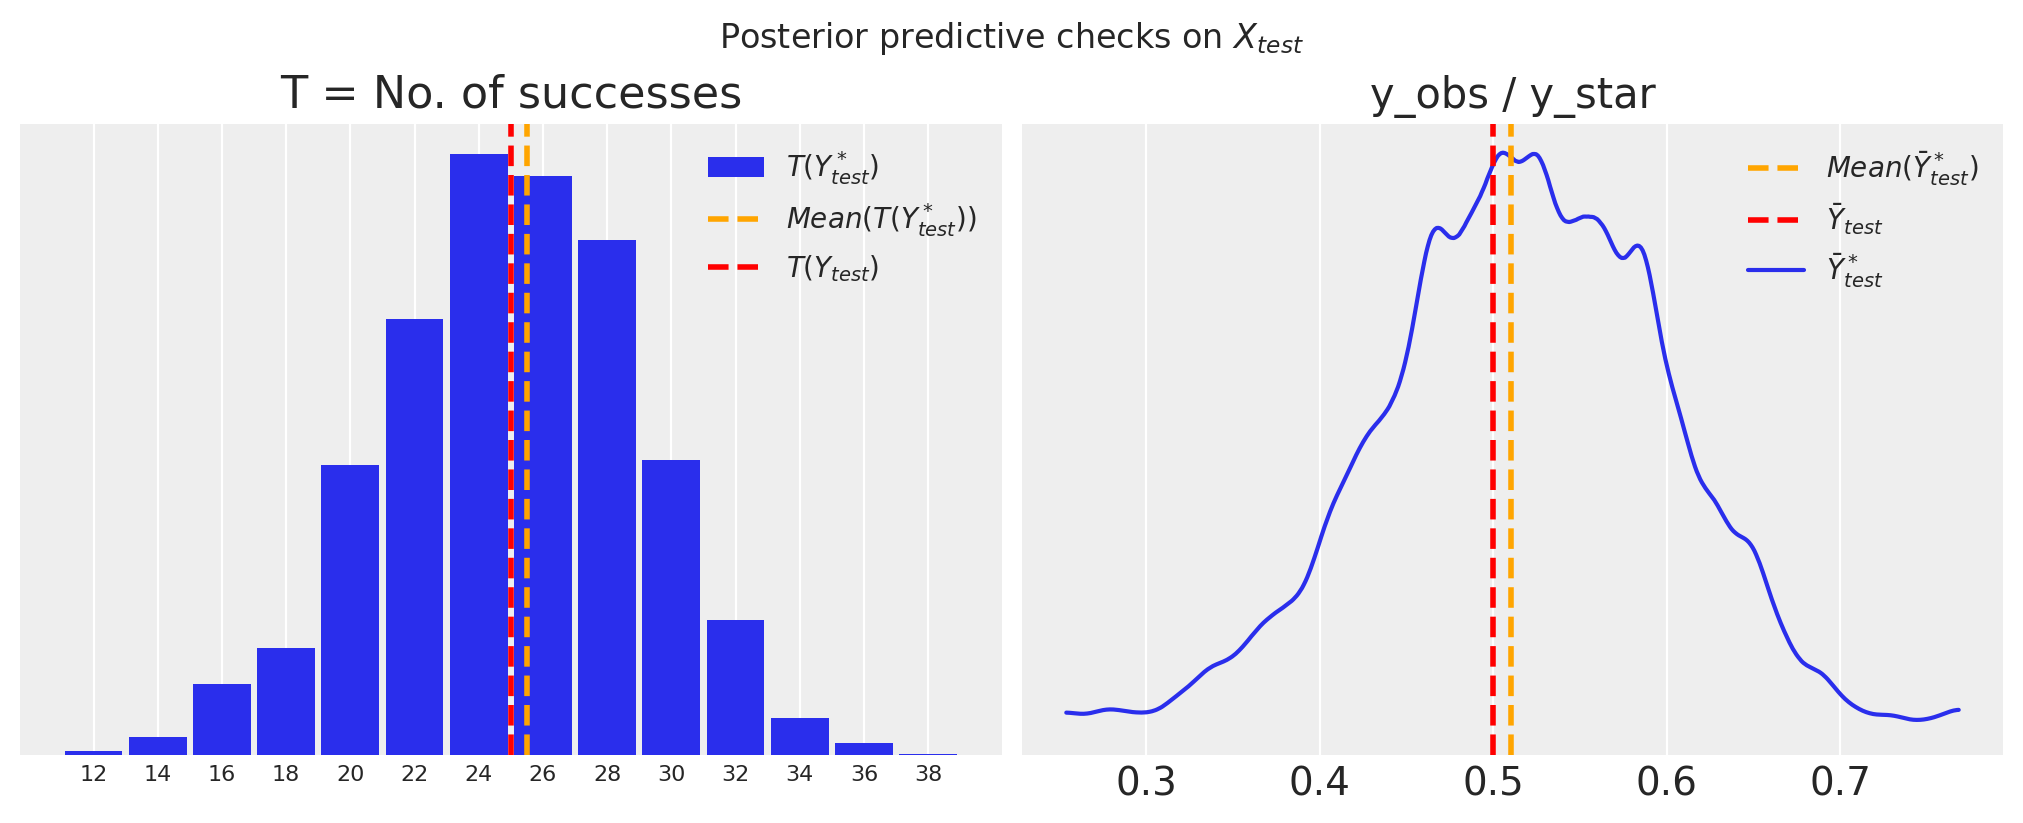

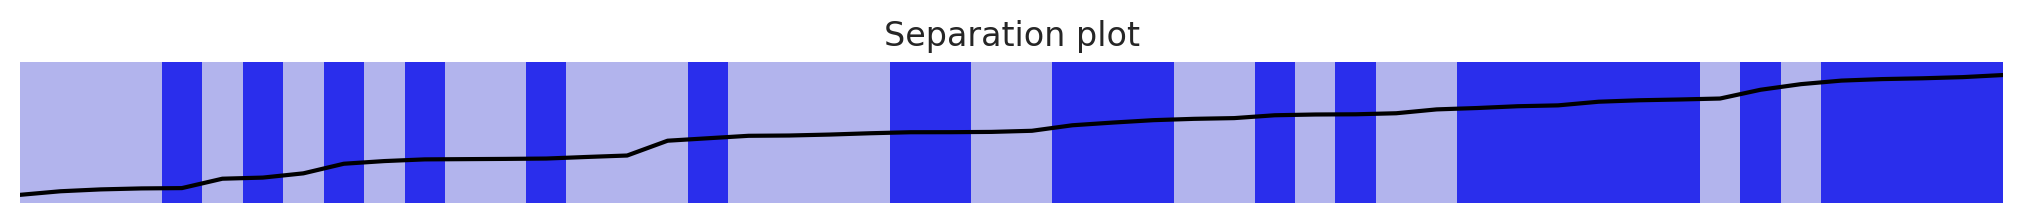

In [33]:
# -- Generate and plot posterior predictive samples from X_test

pp_test_p, pp_test_y = bayesian_model.generate_pp(
    idata_pymc, X_test, theta_space,
    rng=rng, kind='logistic', verbose=True)
idata_pp_test = utils.pp_to_idata(
    [pp_test_p, pp_test_y], idata_pymc, 
    ["p_star", "y_star"], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test_y, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the MSE when using several point-estimates for the parameters.

In [34]:
# -- Compute metrics using several point estimates

df_metrics_pymc = None

# Posterior mean estimates
strategies = [("posterior_mean", pp_test_p), ("posterior_vote", pp_test_y)]
for name, pp in strategies:
    Y_pred_pp = [utils.apply_threshold(y)
                 for y in pp[:, ::thin_pp, :].mean(axis=(0, 1))]
    df_metrics_pymc = utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pp,
        clf_pymc.n_components(name),
        "pymc_" + name,
        df=df_metrics_pymc,
        sort_by=sort_by
    )

# Point estimates
for pe in clf_pymc.default_point_estimates:
    Y_pred_pe = clf_pymc.predict(X_test, strategy=pe)
    df_metrics_pymc = utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pe,
        clf_pymc.n_components(pe),
        "pymc_" + pe,
        df=df_metrics_pymc,
        sort_by=sort_by,
    )

df_metrics_pymc.style.hide(axis="index")

In [35]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = None

for pe in clf_pymc.default_point_estimates:
    X_red = clf_pymc.transform(X, pe=pe)
    X_test_red = clf_pymc.transform(X_test, pe=pe)

    df_metrics_pymc_var_sel = utils.multiple_logistic_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="pymc",
        pe=pe,
        df=df_metrics_pymc_var_sel,
        random_state=SEED
    )

df_metrics_pymc_var_sel.style.hide(axis="index")

### Save & Load

In [ ]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-logistic.nc")

In [ ]:
# -- Load

idata_pymc = az.from_netcdf("pymc-logistic.nc")

## Notebook metadata

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jun 03 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.30.1

json      : 2.0.9
matplotlib: 3.5.2
sys       : 3.9.13 (main, May 19 2022, 08:22:48) 
[GCC 12.1.0]
pandas    : 1.4.2
pymc3     : 3.11.5
autopep8  : 1.6.0
arviz     : 0.12.1
numpy     : 1.22.1
emcee     : 3.1.2
skfda     : 0.0

Watermark: 2.2.0

